OsmoFlux notebook

This notebook contains multiple electrical/hydraulic abstractions of a Reverse Electrodialysis (RED) stack. All of them share the same high-level physical ingredients:
	•	A salinity gradient produces an electromotive force (EMF / “OCV”) via Nernst-type relations.
	•	Current flowing through the stack causes (i) ohmic losses and (ii) salt transport that changes concentrations along the flow direction.
	•	Power delivered to an external load depends on the operating point set by the load (or MPPT).

The models differ mainly in how they treat axial variation and electrical topology.
Additional comment

⸻

Coordinate picture and topology (what “axial” means here)
	•	Flow evolves along a single “axial” direction (call it y): inlet → outlet.
	•	The model assumes uniformity across the membrane span (x) and across the stacking direction (z) within each axial slice.
	•	Cell pairs are stacked in the z direction between one electrode pair at the ends of the stack.

Hydraulics (common assumption used here):
	•	Cell pairs are hydraulic parallel (manifolds distribute the streams across pairs).
	•	Axial slices are hydraulic series (bulk concentrations evolve slice-by-slice along the flow path).

⸻

Core input variables and conventions (shared)

Area and scale:
	•	A_MEM_M2 = active membrane area per cell pair m² / cell pair.
	•	N_CELL_PAIRS = number of cell pairs in electrical series.
	•	Total active area used for power density: A_total = A_MEM_M2 * N_CELL_PAIRS.

Flow convention:
	•	Q_H_M3_S, Q_L_M3_S are total stack volumetric flow rates m³/s, not per pair.
	•	If per-pair flow is needed later: Q_per_pair = Q_total / N_CELL_PAIRS.

Axial discretization:
	•	N_SEG = number of axial segments used to march concentrations along the flow direction.
	•	Each segment represents a control volume for advection + salt transfer updates.

Outputs (common):
	•	V_TERM_V terminal voltage at the electrodes V
	•	I_TOTAL_A total stack current A
	•	P_TOTAL_W delivered electrical power W
	•	P_DENS_W_M2 = P_TOTAL_W / (A_MEM_M2 * N_CELL_PAIRS) W/m²
	•	per_segment[...] arrays for concentrations, segment EMFs, segment resistances, etc.

⸻

Model 0D (lumped “no-axial-variation” baseline)

Purpose:
	•	Fast baseline for sanity checks and parameter sweeps.
	•	Treats the stack as a single equivalent source with one EMF and one internal resistance based on inlet (or bulk) conditions.

Electrical abstraction:
	•	A single Thevenin element: V = E_stack − I * R_int.
	•	No explicit axial concentration depletion; concentration is treated as uniform / averaged.

Implication:
	•	0D can overestimate performance when axial depletion and polarization would reduce EMF and increase effective resistance.

⸻

Model 1D axial — two electrical topologies

Both 1D models resolve bulk concentration evolution along the flow direction by splitting the flow path into N_SEG slices. The difference is how those slices are connected electrically.

A) Legacy 1D axial model (parallel-branch / segmented-electrode-equivalent)

What it assumes electrically:
	•	Axial segments are treated as electrically parallel branches that share the same V_TERM_V.
	•	Each segment carries its own branch current I_SEG[j].

This is physically consistent only for:
	•	A segmented-electrode / multi-converter design (each axial section effectively has its own electrode pair or independent electrical extraction).

Why it is kept:
	•	It matches the original spreadsheet-style implementation and provides a regression baseline for plots and outputs.

Key computational structure:
	•	Iterate on a shared terminal voltage V_TERM_V.
	•	For each segment, compute local E_seg[j] and R_seg[j], then compute I_SEG[j].
	•	Sum currents: I_TOTAL_A = Σ I_SEG[j].
	•	Update V_TERM_V by the external closure (fixed load or MPPT).

Important caution:
	•	Because the model’s electrical degrees of freedom are larger than a standard stack, it can show behaviors that are artifacts for a single-electrode device (for example, multiple segments appearing “blocked” simultaneously under a high initial V_TERM_V).

⸻

B) Standard 1D axial model (series-current / single-electrode-pair Tier A)

What it assumes electrically:
	•	There is one electrode pair, therefore one stack current I_TOTAL_A.
	•	The same I_TOTAL_A flows through every axial location.
	•	Axial segmentation is a series decomposition used for concentration bookkeeping, not electrical branching.

Electrical composition:
	•	Each segment has a local EMF and resistance determined by its local concentrations:
	•	E_seg[j] = E(C_H[j], C_L[j])
	•	R_seg[j] = R(C_H[j], C_L[j], params)
	•	Totals are series sums:
	•	E_total = Σ E_seg[j]
	•	R_int = Σ R_seg[j]
	•	Terminal voltage is then:
	•	V_TERM_V = E_total − I_TOTAL_A * R_int

Key computational structure:
	•	Solve for the single unknown I_TOTAL_A using the external electrical closure.
	•	For a trial current I, march concentrations along the axis (advection + salt transfer), compute E_total(I) and R_int(I), then evaluate the closure residual.
	•	Use a robust scalar solver (bracketing/bisection) to find the operating current.

This model is the physically correct starting point for a conventional RED stack and is the intended base for adding fouling and other real losses without changing topology.

⸻

External electrical “modes” (applies to 0D and both 1D models)

MODE = 'fixed_load'
	•	External resistance R_LOAD_OHM is specified.
	•	Operating point satisfies: V_TERM_V = I_TOTAL_A * R_LOAD_OHM.

MODE = 'max_power'
	•	Ideal maximum power transfer condition at the terminals (Thevenin): R_LOAD ≈ R_int.
	•	Implemented as an operating condition rather than a fixed R_LOAD_OHM.

MODE = 'mppt'
	•	The notebook uses an MPPT-style outer loop that updates an effective load toward the internal resistance estimate.
	•	This is a control abstraction for matching load to source over time/iterations; it does not change the underlying physical topology.

⸻

Fouling and “Tiering” strategy (how future complexity is meant to enter)

Tier A (implemented for the standard topology):
	•	1D axial, series-current, single I_TOTAL_A.
	•	Cleanest place to start adding fouling: apply multipliers to R_seg[j] and track how resistance grows axially.

Tier B/C/D (planned knobs, not required for Tier A regression):
	•	Add one effect at a time behind explicit switches:
	•	concentration polarization (CP)
	•	non-ideal activities
	•	electrode losses
	•	shunt currents / manifold leakage
	•	Cross-flow is inherently 2D in bulk fields; it should not be approximated by axial electrical parallel branches.
	•	Segmented-electrode behavior is already represented by the legacy parallel-branch model and should remain a distinct topology option.

⸻

Practical reading guide (what to run when comparing models)
	•	Use 0D for quick sanity checks and “order-of-magnitude” expectations.
	•	Use 1D series-current when the goal is realism for a standard stack and when adding fouling.
	•	Use 1D legacy parallel-branch only when intentionally exploring segmented-electrode behavior or maintaining regression against older outputs.

Both 1D models return the same output schema so plots can be produced consistently and comparisons can be made directly.

## Variables
Constants, unit conversions, and model-wide options/toggles.

In [1]:
from __future__ import annotations

from dataclasses import dataclass, replace, asdict
from typing import Dict, Any, Optional, Literal, Tuple
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Physical constants (SI)
# -------------------------
F = 96485.33212  # Faraday constant [C/mol]
R = 8.314462618  # Gas constant [J/mol/K]

# Temperature defaults
T_DEFAULT_K = 298.15  # [K] (25 C)

# -------------------------
# Unit conversions
# -------------------------
L_PER_M3 = 1000.0          # [L/m^3]
M3_PER_L = 1.0 / L_PER_M3  # [m^3/L]
PA_PER_BAR = 1e5           # [Pa/bar]

# -------------------------
# Model options / toggles
# -------------------------
@dataclass(frozen=True)
class ModelOptions:
    """Big fixed switches / constants that were previously in the sheet's 'ModelOption' tab.
    Small and stable; run-specific things in DesignInputs.
    """
    # Activity coefficient handling (starting simple)
    USE_ACTIVITY_COEFF: bool = False

    # If True, clamp concentrations to a small positive floor to avoid log/negative issues
    CLAMP_CONC_POSITIVE: bool = True
    CONC_FLOOR_MOL_L: float = 1e-9  # [mol/L]

    # Numerical knobs for axial fixed-point iteration
    MAX_ITERS: int = 200
    REL_TOL: float = 1e-7
    ABS_TOL: float = 1e-10
    DAMPING: float = 0.35  # 0<damping<=1, lower = more stable

    # Whether to store per-iteration diagnostics (slower)
    STORE_ITER_DIAGNOSTICS: bool = False


OPTIONS = ModelOptions()


## nacl_conductivity
Spreadsheet-style NaCl conductivity correlation.
The function signature is:
`KAPPA_NACL_SI(c_mol_L, T_K) -> S_per_m`


In [2]:
# -------------------------
# NaCl conductivity (kappa)
# -------------------------

import numpy as np

# Molar mass of NaCl
MW_NACL_G_PER_MOL = 58.44277  # [g/mol]

# 25C table (Foxboro/Gilson), stored as mg/L -> conductivity at 25C
# Using the mS/cm column.
NACL_MG_L_TABLE = np.array([
    1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 50000, 100000, 200000
], dtype=float)  # [mg/L]

NACL_KAPPA_MS_CM_25C_TABLE = np.array([
    0.0022, 0.0065, 0.0214, 0.064, 0.21, 0.617, 1.99, 5.69, 17.6, 48.6, 78.3, 140.0, 226.0
], dtype=float)  # [mS/cm] at 25C

# Unit conversion:
# 1 mS/cm = 0.1 S/m
MS_CM_TO_S_M = 0.1

# Optional temperature correction (OFF by default to match 25C data exactly)
# set USE_TEMP_CORRECTION = False
# and adjust TEMP_COEFF_PER_K to match the sheet.
USE_TEMP_CORRECTION = False
T_REF_K = 298.15
TEMP_COEFF_PER_K = 0.0212  # crude placeholder, only used if USE_TEMP_CORRECTION = False


def _mol_L_to_mg_L_nacl(c_mol_L: float) -> float:
    """Convert NaCl concentration from mol/L -> mg/L."""
    # mol/L * g/mol = g/L; *1000 => mg/L
    return float(c_mol_L) * MW_NACL_G_PER_MOL * 1000.0


def kappa_nacl_fit_default(c_mol_L: float, T_K: float) -> float:
    """
    Conductivity κ for aqueous NaCl.

    INPUTS:
      - c_mol_L: NaCl concentration [mol/L]
      - T_K: temperature [K]

    OUTPUT:
      - κ [S/m]

    Data basis:
      - Foxboro/Gilson table values at 25C (298.15 K), from sheet.

    Implementation:
      - Convert mol/L -> mg/L
      - Interpolate κ in log-log space versus mg/L
      - Convert mS/cm -> S/m
      - Optional temperature correction (disabled by default)
    """
    c = max(float(c_mol_L), 0.0)
    T = float(T_K)

    # Convert concentration to mg/L for lookup
    mg_L = _mol_L_to_mg_L_nacl(c)
    min_mg_L, max_mg_L = NACL_TABLE_RANGE_MG_L()
    is_out_of_range = (mg_L < min_mg_L) or (mg_L > max_mg_L)



    # Clamp to table range to avoid nonsense at extreme extrapolation
    mg_L_clamped = min(max(mg_L, NACL_MG_L_TABLE[0]), NACL_MG_L_TABLE[-1])

    # Convert table κ to SI [S/m]
    kappa_S_m_table = NACL_KAPPA_MS_CM_25C_TABLE * MS_CM_TO_S_M  # [S/m] at 25C

    # Log-log interpolation across decades
    x = np.log10(NACL_MG_L_TABLE)
    y = np.log10(kappa_S_m_table)
    kappa_25C = 10 ** np.interp(np.log10(mg_L_clamped), x, y)  # [S/m] at 25C

    if USE_TEMP_CORRECTION:
        # Simple linearized correction; replace with sheet’s exact rule if needed
        kappa = kappa_25C * max(1.0 + TEMP_COEFF_PER_K * (T - T_REF_K), 0.0)
    else:
        kappa = kappa_25C

    # Safety floor to avoid divide-by-zero elsewhere
    return float(max(kappa, 1e-9))


def KAPPA_NACL_SI(c_mol_L: float, T_K: float) -> float:
    """Public wrapper: NaCl conductivity in SI units [S/m]."""
    return kappa_nacl_fit_default(c_mol_L, T_K)


# Quick sanity checks against Google sheet table (at 25C):
# We convert mg/L -> mol/L and verify κ comes back close (interpolation exact on table points)
def _mg_L_to_mol_L_nacl(mg_L: float) -> float:
    return float(mg_L) / 1000.0 / MW_NACL_G_PER_MOL  # mg/L -> g/L -> mol/L

def NACL_TABLE_RANGE_MG_L() -> tuple[float, float]:
    """Return (min_mg_L, max_mg_L) covered by the conductivity table."""
    return float(NACL_MG_L_TABLE[0]), float(NACL_MG_L_TABLE[-1])


print("Sanity check vs table points (25C):")
for mg_L, ms_cm in zip(NACL_MG_L_TABLE, NACL_KAPPA_MS_CM_25C_TABLE):
    c_mol_L = _mg_L_to_mol_L_nacl(mg_L)
    kappa_pred_S_m = KAPPA_NACL_SI(c_mol_L, 298.15)
    kappa_true_S_m = ms_cm * MS_CM_TO_S_M
    rel_err = (kappa_pred_S_m - kappa_true_S_m) / kappa_true_S_m
    print(f"mg/L={mg_L:>7.0f}  κ_true={kappa_true_S_m:>10.6g} S/m  κ_pred={kappa_pred_S_m:>10.6g} S/m  rel_err={rel_err:+.2e}")

Sanity check vs table points (25C):
mg/L=      1  κ_true=   0.00022 S/m  κ_pred=   0.00022 S/m  rel_err=-2.46e-16
mg/L=      3  κ_true=   0.00065 S/m  κ_pred=   0.00065 S/m  rel_err=+3.34e-16
mg/L=     10  κ_true=   0.00214 S/m  κ_pred=   0.00214 S/m  rel_err=+4.05e-16
mg/L=     30  κ_true=    0.0064 S/m  κ_pred=    0.0064 S/m  rel_err=-2.71e-16
mg/L=    100  κ_true=     0.021 S/m  κ_pred=     0.021 S/m  rel_err=+0.00e+00
mg/L=    300  κ_true=    0.0617 S/m  κ_pred=    0.0617 S/m  rel_err=+1.12e-16
mg/L=   1000  κ_true=     0.199 S/m  κ_pred=     0.199 S/m  rel_err=+1.39e-16
mg/L=   3000  κ_true=     0.569 S/m  κ_pred=     0.569 S/m  rel_err=+0.00e+00
mg/L=  10000  κ_true=      1.76 S/m  κ_pred=      1.76 S/m  rel_err=+0.00e+00
mg/L=  30000  κ_true=      4.86 S/m  κ_pred=      4.86 S/m  rel_err=+0.00e+00
mg/L=  50000  κ_true=      7.83 S/m  κ_pred=      7.83 S/m  rel_err=+1.13e-16
mg/L= 100000  κ_true=        14 S/m  κ_pred=        14 S/m  rel_err=-1.27e-16
mg/L= 200000  κ_true=      2

## design_inputs (per run)
A run-specific parameter container.

This is the place to mirror sheet's **3-DesignInputs** tab variable names.

The class is immutable (`frozen=True`) so cloning is simple: `replace(params, FIELD=value)`.

In [3]:
# -------------------------
# Run-specific inputs
# -------------------------
@dataclass(frozen=True)
class DesignInputs:
    # ---- Core thermodynamics ----
    T_K: float = T_DEFAULT_K  # temperature [K]

    # ---- Stack topology ----
    N_CELL_PAIRS: int = 10  # number of cell pairs (variable per run) [count]
    A_MEM_M2: float = 0.5   # active membrane area per cell pair [m^2]
    
    # ---- Hydraulics ----
    # Volumetric flow rates for high-salinity (H) and low-salinity (L) streams
    Q_H_M3_S: float = 1.0e-5  # [m^3/s]  # TOTAL stack high-stream flow [m^3/s] (not per pair)
    Q_L_M3_S: float = 1.0e-5  # [m^3/s]  # TOTAL stack low-stream flow [m^3/s] (not per pair)

    # Inlet concentrations (NaCl), mol/L
    C_H_IN_MOL_L: float = 0.5   # [mol/L]
    C_L_IN_MOL_L: float = 0.02  # [mol/L]

    # ---- Channel geometry (used for solution resistance models) ----
    GAP_M: float = 200e-6     # intermembrane gap / spacer thickness [m]
    # model spacer porosity or tortuosity -- add here later

    # ---- Membrane / electrochemical parameters ----
    ALPHA_PERM: float = 0.9   # permselectivity factor (0..1)
    BETA: float = 1.0         # charge efficiency / salt transfer efficiency (0..1)
    
    # Area-specific resistances (ASR) [ohm*m^2] (typical spreadsheet inputs)
    ASR_AEM_OHM_M2: float = 2.0e-4  # [Ω·m^2]
    ASR_CEM_OHM_M2: float = 2.0e-4  # [Ω·m^2]

    # Optional extra ASR terms (spacer, electrodes, manifolds, contacts)
    ASR_EXTRA_OHM_M2: float = 0.0   # [Ω·m^2]

    # ---- External electrical closure ----
    MODE: Literal["fixed_load", "max_power", "mppt"] = "fixed_load"
    R_LOAD_OHM: float = 0.05  # [Ω] used if MODE='fixed_load' (also default MPPT init); near R_int for base-case stack

    # ---- MPPT (maximum power point tracking) knobs ----
    # MPPT is modeled as a controller that selects an effective load resistance.
    # In steady-state, the oracle optimum is near R_load ~= R_int (Thevenin match),
    # but controller limits (step size / inefficiency) can be imposed here.
    MPPT_ETA: float = 1.0  # [0..1] electrical efficiency multiplier applied to delivered power
    MPPT_ALPHA: float = 0.5  # [0..1] per-iteration fractional move toward estimated optimum
    MPPT_MAX_DELTA_R_OHM: float = 5.0  # [Ω/iter] clamp on how fast the controller can change R_load
    MPPT_N_ITERS: int = 8  # controller update iterations used in 0D; 1D updates once per fixed-point iter
    MPPT_R_INIT_OHM: Optional[float] = None  # optional initial MPPT load override [Ω]

    # ---- 1D axial discretization ----
    N_SEG: int = 20  # number of axial segments [count]

    # ---- Fouling / degradation ----
    FOULING_MODEL: str = "none"  # none|linear|exp_inlet|exp_outlet|gaussian|logistic|covalent_ions

    # Fixed-point initialization / stabilization (optional overrides per run)
    INIT_V_TERM_V: Optional[float] = None  # initial guess terminal voltage [V]

    # Placeholder for future cost & pumping parameters (add without refactor)
    # COST_MEMBRANE_PER_M2: float = 0.0
    # PRICE_ELECTRICITY_PER_KWH: float = 0.0
    # DELTA_P_PA: float = 0.0


def clone_params(p: DesignInputs, **updates) -> DesignInputs:
    """Convenience wrapper for sweeps. Equivalent to dataclasses.replace."""
    return replace(p, **updates)


# Display the exact fields (so we can align with the sheet)
print("DesignInputs fields:\n - " + "\n - ".join(DesignInputs.__dataclass_fields__.keys()))


DesignInputs fields:
 - T_K
 - N_CELL_PAIRS
 - A_MEM_M2
 - Q_H_M3_S
 - Q_L_M3_S
 - C_H_IN_MOL_L
 - C_L_IN_MOL_L
 - GAP_M
 - ALPHA_PERM
 - BETA
 - ASR_AEM_OHM_M2
 - ASR_CEM_OHM_M2
 - ASR_EXTRA_OHM_M2
 - MODE
 - R_LOAD_OHM
 - MPPT_ETA
 - MPPT_ALPHA
 - MPPT_MAX_DELTA_R_OHM
 - MPPT_N_ITERS
 - MPPT_R_INIT_OHM
 - N_SEG
 - FOULING_MODEL
 - INIT_V_TERM_V


In [4]:
# -------------------------
# BASELINE RESET (single source of truth)
# -------------------------
# This cell is the ONLY place where baseline inputs are constructed.
# All legacy and harness sweeps must reference these objects ONLY.
# Do not mutate these objects in-place.

GLOBAL_MODE = "fixed_load"

base_ref = DesignInputs(
    # --- Legacy-parity defaults (do not change without updating parity expectations) ---
    N_CELL_PAIRS=10,
    R_LOAD_OHM=1.0,
    A_MEM_M2=0.0100,          # per cell-pair membrane area (legacy convention)
)

# Sweep grids (legacy parity)
R_LOAD_vals_legacy = [0.25, 0.5, 1.0, 2.0, 4.0, 8.0]
N_vals_legacy = [5, 10, 20, 40]

# Second canonical sweep (area vs pairs), if needed
A_MEM_vals_legacy = [0.0025, 0.005, 0.01, 0.02, 0.04]

print("[baseline] GLOBAL_MODE =", GLOBAL_MODE)
print("[baseline] base_ref:", base_ref)


[baseline] GLOBAL_MODE = fixed_load
[baseline] base_ref: DesignInputs(T_K=298.15, N_CELL_PAIRS=10, A_MEM_M2=0.01, Q_H_M3_S=1e-05, Q_L_M3_S=1e-05, C_H_IN_MOL_L=0.5, C_L_IN_MOL_L=0.02, GAP_M=0.0002, ALPHA_PERM=0.9, BETA=1.0, ASR_AEM_OHM_M2=0.0002, ASR_CEM_OHM_M2=0.0002, ASR_EXTRA_OHM_M2=0.0, MODE='fixed_load', R_LOAD_OHM=1.0, MPPT_ETA=1.0, MPPT_ALPHA=0.5, MPPT_MAX_DELTA_R_OHM=5.0, MPPT_N_ITERS=8, MPPT_R_INIT_OHM=None, N_SEG=20, FOULING_MODEL='none', INIT_V_TERM_V=None)


## built_in_functions
Helper functions shared by both models: Nernst potential, resistance building blocks, conversions, sanity checks.

In [5]:
# -------------------------
# Shared helpers
# -------------------------

def _clamp_conc(c_mol_L: float) -> float:
    if OPTIONS.CLAMP_CONC_POSITIVE:
        return max(float(c_mol_L), OPTIONS.CONC_FLOOR_MOL_L)
    return float(c_mol_L)


def NERNST_OCV_CELLPAIR_V(C_H_MOL_L: float, C_L_MOL_L: float, T_K: float, ALPHA_PERM: float) -> float:
    """Open-circuit voltage for a single cell pair [V].
    
    Typical spreadsheet form (ideal, monovalent):
      E_cell = 2 * α * (R*T/F) * ln( a_H / a_L )
    where α is permselectivity (0..1). Here a≈c if activity coefficients are ignored.
    """
    cH = _clamp_conc(C_H_MOL_L)
    cL = _clamp_conc(C_L_MOL_L)
    return float(2.0 * ALPHA_PERM * (R * T_K / F) * math.log(cH / cL))


def ASR_SOLUTION_OHM_M2(C_MOL_L: float, T_K: float, GAP_M: float) -> float:
    """Solution area-specific resistance [Ω·m^2] for one channel gap.
    
    Simple model:
      ASR_sol = GAP / κ
    where κ is conductivity [S/m].
    
    If the sheet uses a more detailed spacer model, replace this exactly.
    """
    kappa = KAPPA_NACL_SI(C_MOL_L, T_K)  # [S/m]
    return float(GAP_M / kappa)  # [Ω·m^2]


def ASR_CELLPAIR_OHM_M2(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Total area-specific resistance per cell pair [Ω·m^2]."""
    asr_sol_H = ASR_SOLUTION_OHM_M2(C_H_MOL_L, p.T_K, p.GAP_M)
    asr_sol_L = ASR_SOLUTION_OHM_M2(C_L_MOL_L, p.T_K, p.GAP_M)
    return float(p.ASR_AEM_OHM_M2 + p.ASR_CEM_OHM_M2 + asr_sol_H + asr_sol_L + p.ASR_EXTRA_OHM_M2)


def R_STACK_INTERNAL_OHM(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Internal resistance of the whole stack [Ω] at given concentrations."""
    asr = ASR_CELLPAIR_OHM_M2(p, C_H_MOL_L, C_L_MOL_L)   # [Ω·m^2] per cell pair
    r_cellpair = asr / p.A_MEM_M2                        # [Ω] per cell pair
    return float(p.N_CELL_PAIRS * r_cellpair)            # series


def E_STACK_OCV_V(p: DesignInputs, C_H_MOL_L: float, C_L_MOL_L: float) -> float:
    """Stack OCV [V] = N_CELL_PAIRS * E_cellpair."""
    e_cell = NERNST_OCV_CELLPAIR_V(C_H_MOL_L, C_L_MOL_L, p.T_K, p.ALPHA_PERM)
    return float(p.N_CELL_PAIRS * e_cell)


def salt_transfer_mol_per_s(I_A: float, N_CELL_PAIRS: int, BETA: float) -> float:
    """Faradaic NaCl transfer rate [mol/s] from H->L implied by current.
    
    For monovalent ions, charge flow I corresponds to mol/s = I/F.
    In a RED stack, each cell pair contributes; with N in series, current is common,
    so total mol/s transfer scales with N (spreadsheet convention often uses N).
    
    BETA is a catch-all for charge efficiency / leakage effects (0..1).
    """
    return float(BETA * I_A * N_CELL_PAIRS / F)


def apply_salt_balance(
    C_H_IN_MOL_L: float, C_L_IN_MOL_L: float,
    Q_H_M3_S: float, Q_L_M3_S: float,
    n_dot_mol_s: float
) -> Tuple[float, float]:
    """Update outlet concentrations from a segment given salt transfer n_dot [mol/s].
    
    Convention: +n_dot means NaCl moves from high-salinity stream to low-salinity stream.
    
    Mass balance:
      ΔC_H = -n_dot / Q_H   (mol/m^3) then convert to mol/L
      ΔC_L = +n_dot / Q_L
    """
    # mol/m^3
    dC_H_mol_m3 = -n_dot_mol_s / max(Q_H_M3_S, 1e-30)
    dC_L_mol_m3 = +n_dot_mol_s / max(Q_L_M3_S, 1e-30)

    # convert to mol/L
    dC_H_mol_L = dC_H_mol_m3 / L_PER_M3
    dC_L_mol_L = dC_L_mol_m3 / L_PER_M3

    C_H_OUT = C_H_IN_MOL_L + dC_H_mol_L
    C_L_OUT = C_L_IN_MOL_L + dC_L_mol_L

    # Clamp to non-negative if requested
    if OPTIONS.CLAMP_CONC_POSITIVE:
        C_H_OUT = max(C_H_OUT, OPTIONS.CONC_FLOOR_MOL_L)
        C_L_OUT = max(C_L_OUT, OPTIONS.CONC_FLOOR_MOL_L)

    return float(C_H_OUT), float(C_L_OUT)


def sanity_check_inputs(p: DesignInputs) -> None:
    assert p.N_CELL_PAIRS >= 1
    assert p.N_SEG >= 1
    assert p.A_MEM_M2 > 0
    assert p.Q_H_M3_S > 0 and p.Q_L_M3_S > 0
    assert p.C_H_IN_MOL_L > 0 and p.C_L_IN_MOL_L > 0
    assert 0 <= p.ALPHA_PERM <= 1.0
    assert 0 <= p.BETA <= 1.0
    assert p.GAP_M > 0


# -------------------------
# MPPT helpers (electrical closure)
# -------------------------

def _clamp_positive_ohms(r_ohm: float, floor_ohm: float = 1e-6) -> float:
    """Clamp a resistance to a small positive value to avoid division-by-zero."""
    return float(max(float(r_ohm), float(floor_ohm)))

def _mppt_update_r_load(r_load_ohm: float, r_opt_ohm: float, alpha: float, max_delta_ohm: float) -> float:
    """Single MPPT controller update step toward an estimated optimal load (controller-limited)."""
    r_load = _clamp_positive_ohms(r_load_ohm)
    r_opt = _clamp_positive_ohms(r_opt_ohm)
    a = float(min(max(alpha, 0.0), 1.0))
    max_d = float(max(max_delta_ohm, 0.0))

    # Move fractionally toward r_opt with an absolute delta clamp (models finite controller bandwidth).
    r_target = (1.0 - a) * r_load + a * r_opt
    delta = r_target - r_load
    if max_d > 0.0:
        delta = float(np.clip(delta, -max_d, +max_d))
    return _clamp_positive_ohms(r_load + delta)

def _mppt_init_r_load(p: DesignInputs) -> float:
    """Initialize MPPT load resistance from overrides (falls back to R_LOAD_OHM)."""
    r0 = p.MPPT_R_INIT_OHM if p.MPPT_R_INIT_OHM is not None else p.R_LOAD_OHM
    return _clamp_positive_ohms(float(r0))


## 5) model functions
Two pure functions:
- `model_0d(params)`
- `model_1d_axial(params, mode=...)`

Return type: structured dict with both scalar outputs and per-segment arrays.
Axial model uses a fixed-point iterative loop with damping (no circular refs).

In [6]:
# -------------------------
# 0D model
# -------------------------
def model_0d(p: DesignInputs, mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None) -> Dict[str, Any]:
    sanity_check_inputs(p)
    mode = mode or p.MODE

    # Treat as single lump with inlet concentrations
    C_H = p.C_H_IN_MOL_L
    C_L = p.C_L_IN_MOL_L

    E_ocv = E_STACK_OCV_V(p, C_H, C_L)         # [V]
    R_int = R_STACK_INTERNAL_OHM(p, C_H, C_L)  # [Ω]

    if mode == "fixed_load":
        R_load = float(p.R_LOAD_OHM)
        I = E_ocv / (R_int + R_load)  # [A]
        V_term = I * R_load           # [V]
    elif mode == "max_power":
        # Thevenin: max power when R_load = R_int (oracle impedance match)
        R_load = R_int
        I = E_ocv / (R_int + R_load)
        V_term = I * R_load
    elif mode == "mppt":
        # Controller-limited MPPT: iteratively move an effective load toward the estimated optimum.
        # In this steady-state 0D setting, the target optimum is the Thevenin match R_opt ~= R_int.
        R_opt = R_int
        R_load = _mppt_init_r_load(p)
        for _ in range(int(max(p.MPPT_N_ITERS, 0))):
            R_load = _mppt_update_r_load(R_load, R_opt, p.MPPT_ALPHA, p.MPPT_MAX_DELTA_R_OHM)
        I = E_ocv / (R_int + R_load)
        V_term = I * R_load
    else:
        raise ValueError(f"Unknown mode: {mode}")

    P_raw = V_term * I  # [W] (ideal electrical power into the selected load)
    eta = float(p.MPPT_ETA) if mode == "mppt" else 1.0
    P = float(P_raw * eta)  # [W] delivered power (after MPPT efficiency)

    n_dot = salt_transfer_mol_per_s(I, p.N_CELL_PAIRS, p.BETA)  # [mol/s]
    C_H_OUT, C_L_OUT = apply_salt_balance(C_H, C_L, p.Q_H_M3_S, p.Q_L_M3_S, n_dot)

    return {
        "mode": mode,
        "E_OCV_V": E_ocv,
        "R_INT_OHM": R_int,
        "R_LOAD_OHM": R_load,
        "V_TERM_V": V_term,
        "I_A": I,
        "P_W": P,
        "P_RAW_W": float(P_raw),
        "MPPT_ETA": float(eta),
        "C_H_OUT_MOL_L": C_H_OUT,
        "C_L_OUT_MOL_L": C_L_OUT,
        "n_dot_salt_mol_s": n_dot,
    }


# -------------------------
# 1D axial model
# -------------------------

# -------------------------
# Fouling / degradation models (axial)
# -------------------------
def _x_seg(j: int, N: int) -> float:
    """Normalized axial coordinate in [0,1] at segment center."""
    return (j + 0.5) / float(max(N, 1))

def fouling_none(x: float) -> float:
    """No added resistance."""
    return 0.0

def fouling_linear(x: float) -> float:
    """Linear fouling ramp along flow (quick first test)."""
    beta = 0.30  # max fractional resistance increase at outlet (x=1)
    return beta * x

def fouling_exp_inlet(x: float) -> float:
    """Inlet-peaked fouling (decays downstream)."""
    beta = 0.40
    k = 4.0
    return beta * float(np.exp(-k * x))

def fouling_exp_outlet(x: float) -> float:
    """Outlet-peaked fouling (grows downstream)."""
    beta = 0.40
    k = 4.0
    num = float(np.exp(k * x) - 1.0)
    den = float(np.exp(k) - 1.0)
    return beta * (num / max(den, 1e-30))

def fouling_gaussian_hotspot(x: float) -> float:
    """Localized hotspot (e.g., precipitation zone)."""
    beta = 0.60
    x0 = 0.65
    sigma = 0.10
    return beta * float(np.exp(-0.5 * ((x - x0) / max(sigma, 1e-30)) ** 2))

def fouling_logistic(x: float) -> float:
    """Saturating fouling (growth then plateau)."""
    beta = 0.50
    k = 10.0
    x0 = 0.35
    return beta * float(1.0 / (1.0 + np.exp(-k * (x - x0))))

def fouling_covalent_ions(x: float) -> float:
    """Shell: covalent-ion / complexing species that disproportionately suppresses power.
    Placeholder: steep early resistance penalty.
    """
    # TODO: replace with a mechanistic mapping from (divalent/covalent fraction, pH, local conc) -> penalty
    beta = 1.00
    x0 = 0.20
    k = 18.0
    return beta * float(1.0 / (1.0 + np.exp(-k * (x - x0))))

FOULING_FUNCS = {
    "none": fouling_none,
    "linear": fouling_linear,
    "exp_inlet": fouling_exp_inlet,
    "exp_outlet": fouling_exp_outlet,
    "gaussian": fouling_gaussian_hotspot,
    "logistic": fouling_logistic,
    "covalent_ions": fouling_covalent_ions,
}

def segment_resistance_ohm(p: 'DesignInputs', j: int, N: int, R_seg_clean: float) -> float:
    """Return segment resistance including optional fouling multiplier.
    Fouling functions return a *fractional* increase (e.g., 0.3 => +30%).
    """
    key = getattr(p, "FOULING_MODEL", "none") or "none"
    f = FOULING_FUNCS.get(str(key), fouling_none)
    x = _x_seg(j, N)
    frac = float(f(x))
    return float(R_seg_clean) * (1.0 + max(frac, 0.0))


def _axial_branch_params(p: DesignInputs, j: int, C_H: float, C_L: float) -> Tuple[float, float]:
    """Return (E_seg, R_seg) for axial segment j using local concentrations.

    Topology (matches sheet):
      - cell pairs: electrical series -> stack-level E_stack, R_stack
      - axial segments: electrical parallel -> per-branch:
            E_seg = E_stack / N_SEG
            R_seg_clean = R_stack * N_SEG
      - fouling modifies segment resistance only (via segment_resistance_ohm)
    """
    N = int(p.N_SEG)

    # MPPT state (effective load resistance). Initialized once per model evaluation.
    E_stack = float(E_STACK_OCV_V(p, C_H, C_L))         # [V]
    R_stack = float(R_STACK_INTERNAL_OHM(p, C_H, C_L))  # [Ω]

    E_seg = E_stack / float(max(N, 1))
    R_seg_clean = R_stack * float(max(N, 1))
    R_seg = segment_resistance_ohm(p, j=j, N=N, R_seg_clean=R_seg_clean)
    return float(E_seg), float(R_seg)

def _axial_segment_params_series_current(p: DesignInputs, j: int, C_H: float, C_L: float) -> Tuple[float, float]:
    """Return (E_seg, R_seg) for axial segment j using local concentrations.

    Topology (standard single-electrode 1D axial model):
      - cell pairs: electrical series -> stack-level E_stack, R_stack
      - axial segments: electrical series decomposition (bookkeeping), so per-segment contributions sum:
            E_seg = E_stack / N_SEG
            R_seg_clean = R_stack / N_SEG
      - fouling modifies segment resistance only (via segment_resistance_ohm)
    """
    N = int(p.N_SEG)

    E_stack = float(E_STACK_OCV_V(p, C_H, C_L))         # [V]
    R_stack = float(R_STACK_INTERNAL_OHM(p, C_H, C_L))  # [Ω]

    E_seg = E_stack / float(max(N, 1))
    R_seg_clean = R_stack / float(max(N, 1))
    R_seg = segment_resistance_ohm(p, j=j, N=N, R_seg_clean=R_seg_clean)
    return float(E_seg), float(R_seg)




def model_1d_axial(
    p: DesignInputs,
    mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None,
) -> Dict[str, Any]:
    """1D axial RED model.

    Hydraulics: segments in series (outlet of j feeds inlet of j+1).
    Electrical: segments in parallel (common terminal voltage V_term; branch currents distribute).

    Electrical closure:
      - fixed_load: V_term = I_total * R_LOAD_OHM
      - max_power: choose equivalent Thevenin load -> V_term = V_oc_eq/2 (oracle match)
      - mppt: controller-limited effective R_load updated toward R_int_eq, then V_term = I_total * R_load
    """
    sanity_check_inputs(p)
    mode = mode or p.MODE
    N = int(p.N_SEG)

    # Arrays per segment (0..N-1)
    C_H_IN = np.zeros(N, dtype=float)
    C_L_IN = np.zeros(N, dtype=float)
    C_H_OUT = np.zeros(N, dtype=float)
    C_L_OUT = np.zeros(N, dtype=float)

    E_seg = np.zeros(N, dtype=float)      # [V]
    R_seg = np.zeros(N, dtype=float)      # [Ω]
    I_seg = np.zeros(N, dtype=float)      # [A]
    n_dot_seg = np.zeros(N, dtype=float)  # [mol/s]

    # Diagnostics / feasibility flags
    min_mg_L, max_mg_L = NACL_TABLE_RANGE_MG_L()
    any_kappa_oob = False
    any_conc_clamped = False
    any_inversion = False

    # Initialize hydraulic inlets
    C_H_IN[0] = p.C_H_IN_MOL_L
    C_L_IN[0] = p.C_L_IN_MOL_L

    # MPPT state (effective load resistance). Initialized once per model evaluation.
    R_load_mppt = _mppt_init_r_load(p) if mode == "mppt" else None

    # Initial guess for terminal voltage
    if p.INIT_V_TERM_V is not None:
        V_term = float(p.INIT_V_TERM_V)
    else:
        V_term = 0.5 * E_STACK_OCV_V(p, p.C_H_IN_MOL_L, p.C_L_IN_MOL_L)

    iter_diag = [] if OPTIONS.STORE_ITER_DIAGNOSTICS else None
    converged = False

    for it in range(OPTIONS.MAX_ITERS):
        V_old = V_term

        # Step 1: march hydraulically, compute local branch params and branch currents
        for j in range(N):
            if j > 0:
                C_H_IN[j] = C_H_OUT[j - 1]
                C_L_IN[j] = C_L_OUT[j - 1]

            # Track concentration validity vs kappa table (mg/L)
            mgL_H = _mol_L_to_mg_L_nacl(C_H_IN[j])
            mgL_L = _mol_L_to_mg_L_nacl(C_L_IN[j])
            if (mgL_H < min_mg_L) or (mgL_H > max_mg_L) or (mgL_L < min_mg_L) or (mgL_L > max_mg_L):
                any_kappa_oob = True

            # Local segment electrochem based on inlet concentrations (sheet often uses inlet or avg; adjust if needed)
            E_seg[j], R_seg[j] = _axial_branch_params(p, j, C_H_IN[j], C_L_IN[j])

            # Branch current given common V_term; clamp to non-negative (no reversal in this model)
            I_seg[j] = max((E_seg[j] - V_term) / max(R_seg[j], 1e-30), 0.0)

            # Salt transfer and outlet concentrations for this segment
            n_dot_seg[j] = salt_transfer_mol_per_s(I_seg[j], p.N_CELL_PAIRS, p.BETA)
            C_H_OUT[j], C_L_OUT[j] = apply_salt_balance(
                C_H_IN[j], C_L_IN[j], p.Q_H_M3_S, p.Q_L_M3_S, n_dot_seg[j]
            )

            # Clamp/inversion diagnostics
            if (C_H_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30) or (C_L_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30):
                any_conc_clamped = True
            if C_L_OUT[j] > C_H_OUT[j]:
                any_inversion = True

        # Step 2: electrical closure update V_term
        if mode == "fixed_load":
            I_total = float(np.sum(I_seg))
            V_new = I_total * float(p.R_LOAD_OHM)
        elif mode == "max_power":
            # Equivalent Thevenin from parallel branches (given local E/R)
            G = np.sum(1.0 / np.maximum(R_seg, 1e-30))  # [1/Ω]
            V_oc_eq = float(np.sum(E_seg / np.maximum(R_seg, 1e-30)) / max(G, 1e-30))
            V_new = 0.5 * V_oc_eq  # max-power choice (oracle impedance match)
        elif mode == "mppt":
            # Controller-limited MPPT: update an effective load toward estimated optimum.
            # For the parallel-branch equivalent, R_opt ~= R_int_eq = 1/G.
            I_total = float(np.sum(I_seg))
            G = np.sum(1.0 / np.maximum(R_seg, 1e-30))  # [1/Ω]
            R_int_eq = float(1.0 / max(G, 1e-30))
            assert R_load_mppt is not None
            R_load_mppt = _mppt_update_r_load(R_load_mppt, R_int_eq, p.MPPT_ALPHA, p.MPPT_MAX_DELTA_R_OHM)
            V_new = I_total * float(R_load_mppt)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        # Damped fixed-point update
        V_term = (1.0 - OPTIONS.DAMPING) * V_old + OPTIONS.DAMPING * V_new

        # Hard physics clamp: V_term cannot exceed the Thevenin OCV of the parallel array.
        # Compute V_oc_eq fresh from the current E_seg / R_seg (concentrations may have changed).
        _G_clamp = np.sum(1.0 / np.maximum(R_seg, 1e-30))
        _V_oc_clamp = float(np.sum(E_seg / np.maximum(R_seg, 1e-30)) / max(_G_clamp, 1e-30))
        V_term = float(np.clip(V_term, 0.0, _V_oc_clamp))

        # Convergence check
        abs_err = abs(V_term - V_old)
        rel_err = abs_err / max(abs(V_old), 1e-12)

        if OPTIONS.STORE_ITER_DIAGNOSTICS:
            iter_diag.append({"iter": it, "V_term": V_term, "abs_err": abs_err, "rel_err": rel_err})

        if abs_err < OPTIONS.ABS_TOL or rel_err < OPTIONS.REL_TOL:
            converged = True
            break

    # Final totals
    I_total = float(np.sum(I_seg))
    P_raw_total = float(V_term * I_total)
    eta = float(p.MPPT_ETA) if mode == "mppt" else 1.0
    P_total = float(P_raw_total * eta)

    # Equivalent internal resistance seen at terminals (parallel combination of R_seg)
    G_tot = float(np.sum(1.0 / np.maximum(R_seg, 1e-30)))
    R_int_eq = float(1.0 / max(G_tot, 1e-30))
    # Open-circuit equivalent voltage at terminals (weighted)
    V_oc_eq = float(np.sum(E_seg / np.maximum(R_seg, 1e-30)) / max(G_tot, 1e-30))

    if mode == "fixed_load":
        R_load = float(p.R_LOAD_OHM)
    elif mode == "mppt":
        R_load = float(R_load_mppt) if R_load_mppt is not None else float(p.R_LOAD_OHM)
    else:
        R_load = R_int_eq

    active_mask = I_seg > 0.0
    frac_active = float(np.mean(active_mask))
    n_active = int(np.sum(active_mask))

    if I_total <= 0.0:
        regime = "blocked"
    elif frac_active < 0.99:
        regime = "partial"
    else:
        regime = "conducting"

    return {
        "mode": mode,
        "converged": converged,
        "iters_used": (it + 1),
        "any_kappa_oob": any_kappa_oob,
        "any_conc_clamped": any_conc_clamped,
        "any_inversion": any_inversion,
        "frac_active_segments": frac_active,
        "n_active_segments": n_active,
        "regime": regime,
        "V_TERM_V": float(V_term),
        "I_TOTAL_A": I_total,
        "P_TOTAL_W": P_total,
        "P_RAW_TOTAL_W": float(P_raw_total),
        "MPPT_ETA": float(eta),
        "R_INT_EQ_OHM": R_int_eq,
        "V_OC_EQ_V": V_oc_eq,
        "R_LOAD_OHM": R_load,
        "per_segment": {
            "C_H_IN_MOL_L": C_H_IN,
            "C_L_IN_MOL_L": C_L_IN,
            "C_H_OUT_MOL_L": C_H_OUT,
            "C_L_OUT_MOL_L": C_L_OUT,
            "E_SEG_V": E_seg,
            "R_SEG_OHM": R_seg,
            "I_SEG_A": I_seg,
            "n_dot_seg_mol_s": n_dot_seg,
        },
        "iter_diagnostics": (pd.DataFrame(iter_diag) if OPTIONS.STORE_ITER_DIAGNOSTICS else None),
    }



# -------------------------
# 1D axial model (STANDARD topology): series-current, single electrode pair
# -------------------------
def _march_axial_given_current(
    p: DesignInputs,
    I: float,
) -> Dict[str, Any]:
    """Hydraulic march with *uniform* axial current I (single-electrode series-current convention).

    Returns totals (E_total, R_total) plus per-segment diagnostics.
    """
    N = int(p.N_SEG)

    C_H_IN = np.zeros(N, dtype=float)
    C_L_IN = np.zeros(N, dtype=float)
    C_H_OUT = np.zeros(N, dtype=float)
    C_L_OUT = np.zeros(N, dtype=float)

    E_seg = np.zeros(N, dtype=float)      # [V] local EMF contribution
    R_seg = np.zeros(N, dtype=float)      # [Ω] local internal resistance contribution
    I_seg = np.full(N, float(I), dtype=float)  # [A] uniform by topology
    n_dot_seg = np.zeros(N, dtype=float)  # [mol/s]

    # Diagnostics / feasibility flags
    min_mg_L, max_mg_L = NACL_TABLE_RANGE_MG_L()
    any_kappa_oob = False
    any_conc_clamped = False
    any_inversion = False

    # Initialize hydraulic inlets
    C_H_IN[0] = p.C_H_IN_MOL_L
    C_L_IN[0] = p.C_L_IN_MOL_L

    for j in range(N):
        if j > 0:
            C_H_IN[j] = C_H_OUT[j - 1]
            C_L_IN[j] = C_L_OUT[j - 1]

        # conductivity table safety check (same convention as legacy)
        mgL_H = _mol_L_to_mg_L_nacl(C_H_IN[j])
        mgL_L = _mol_L_to_mg_L_nacl(C_L_IN[j])
        if (mgL_H < min_mg_L) or (mgL_H > max_mg_L) or (mgL_L < min_mg_L) or (mgL_L > max_mg_L):
            any_kappa_oob = True

        # Local electrical params computed from *local* bulk concentrations
        E_seg[j], R_seg[j] = _axial_segment_params_series_current(p, j, C_H_IN[j], C_L_IN[j])

        # Salt transfer uses the same stack current through this slice
        n_dot_seg[j] = salt_transfer_mol_per_s(float(I), p.N_CELL_PAIRS, p.BETA)

        # Update bulk concentrations by advection + salt flux
        C_H_OUT[j], C_L_OUT[j] = apply_salt_balance(
            C_H_IN[j], C_L_IN[j], p.Q_H_M3_S, p.Q_L_M3_S, n_dot_seg[j]
        )

        if (C_H_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30) or (C_L_OUT[j] <= OPTIONS.CONC_FLOOR_MOL_L + 1e-30):
            any_conc_clamped = True
        if C_L_OUT[j] > C_H_OUT[j]:
            any_inversion = True

    E_total = float(np.sum(E_seg))
    R_total = float(np.sum(R_seg))

    return {
        "E_total": E_total,
        "R_total": R_total,
        "any_kappa_oob": any_kappa_oob,
        "any_conc_clamped": any_conc_clamped,
        "any_inversion": any_inversion,
        "per_segment": {
            "C_H_IN_MOL_L": C_H_IN,
            "C_L_IN_MOL_L": C_L_IN,
            "C_H_OUT_MOL_L": C_H_OUT,
            "C_L_OUT_MOL_L": C_L_OUT,
            "E_SEG_V": E_seg,
            "R_SEG_OHM": R_seg,
            "I_SEG_A": I_seg,
            "n_dot_seg_mol_s": n_dot_seg,
        },
    }


def model_1d_axial_series_current(
    p: DesignInputs,
    mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None,
) -> Dict[str, Any]:
    """1D axial RED model for a standard stack (single electrode pair).

    Hydraulics: segments in series (outlet of j feeds inlet of j+1).
    Electrical: *series-current* (one stack current I flows through every axial location and every cell pair).

    Electrical closure:
      - fixed_load: V_term(I) = I * R_LOAD_OHM
      - max_power: oracle impedance match (R_load = R_int_eq) => V_term = V_oc_eq/2
      - mppt: controller-limited effective R_load updated toward R_int_eq, then V_term = I * R_load
    """
    sanity_check_inputs(p)
    mode = mode or p.MODE

    # MPPT outer loop: update an effective load based on estimated internal resistance.
    if mode == "mppt":
        R_load = _mppt_init_r_load(p)
        diag_steps = []
        res_last = None
        for k in range(int(max(p.MPPT_N_ITERS, 0))):
            res_last = model_1d_axial_series_current(
                replace(p, R_LOAD_OHM=float(R_load)),
                mode="fixed_load",
            )
            R_int = float(res_last["R_INT_EQ_OHM"])
            R_load = _mppt_update_r_load(R_load, R_int, p.MPPT_ALPHA, p.MPPT_MAX_DELTA_R_OHM)
            diag_steps.append({"mppt_iter": k, "R_eff": float(R_load), "R_int": float(R_int), "P_RAW_TOTAL_W": float(res_last["P_RAW_TOTAL_W"])})
        if res_last is None:
            res_last = model_1d_axial_series_current(p, mode="fixed_load")
        res_last["mode"] = "mppt"
        res_last["R_LOAD_OHM"] = float(R_load)
        res_last["mppt_diagnostics"] = pd.DataFrame(diag_steps)
        res_last["MPPT_ETA"] = float(p.MPPT_ETA)
        res_last["P_TOTAL_W"] = float(res_last["P_RAW_TOTAL_W"] * float(p.MPPT_ETA))
        return res_last

    # Define scalar equation in I. Note: E_total and R_total depend on I via concentration evolution.
    def _f(I: float) -> Tuple[float, Dict[str, Any]]:
        march = _march_axial_given_current(p, I)
        E_total = float(march["E_total"])
        R_int = float(march["R_total"])
        V_term = float(E_total - I * R_int)

        if mode == "fixed_load":
            return float(V_term - I * float(p.R_LOAD_OHM)), march
        elif mode == "max_power":
            # For Thevenin source: optimum at R_load = R_int => V_term = I*R_int.
            # So: E_total - I*R_int - I*R_int = 0
            return float(E_total - 2.0 * I * R_int), march
        else:
            raise ValueError(mode)

    # Bracket the root on I >= 0 using a robust expansion strategy.
    f0, march0 = _f(0.0)

    # If f0 <= 0, the model implies no available EMF (should not happen unless E_total is zero).
    if f0 <= 0.0:
        march_star = march0
        I_star = 0.0
        converged = True
        it_used = 0
    else:
        # Start with a heuristic upper bound based on the I=0 Thevenin estimate.
        E0 = float(march0["E_total"])
        R0 = float(march0["R_total"])
        if mode == "fixed_load":
            I_hi = float(E0 / max(R0 + float(p.R_LOAD_OHM), 1e-12)) * 4.0
        else:
            I_hi = float(E0 / max(2.0 * R0, 1e-12)) * 4.0
        I_hi = max(I_hi, 1e-12)

        f_hi, march_hi = _f(I_hi)
        expand = 0
        while (f_hi > 0.0) and (expand < 40):
            I_hi *= 2.0
            f_hi, march_hi = _f(I_hi)
            expand += 1

        if f_hi > 0.0:
            # No sign change found: fall back to I=0 (treat as blocked under current assumptions).
            march_star = march0
            I_star = 0.0
            converged = False
            it_used = 0
        else:
            # Bisection (monotonicity is expected in practice; bisection is robust regardless).
            I_lo = 0.0
            f_lo = f0
            march_star = march0
            I_star = 0.0
            converged = False
            it_used = 0

            for it in range(int(max(OPTIONS.MAX_ITERS, 1))):
                I_mid = 0.5 * (I_lo + I_hi)
                f_mid, march_mid = _f(I_mid)

                march_star = march_mid
                I_star = float(I_mid)
                it_used = it + 1

                if abs(f_mid) < OPTIONS.ABS_TOL:
                    converged = True
                    break

                if f_mid > 0.0:
                    I_lo, f_lo = I_mid, f_mid
                else:
                    I_hi = I_mid

                if abs(I_hi - I_lo) < OPTIONS.ABS_TOL:
                    converged = True
                    break

    # Final outputs (match legacy schema keys as much as possible)
    E_total = float(march_star["E_total"])
    R_int = float(march_star["R_total"])
    V_term = float(E_total - I_star * R_int)
    V_term = max(V_term, 0.0)

    if mode == "fixed_load":
        R_load = float(p.R_LOAD_OHM)
    else:
        R_load = float(R_int)

    P_raw = float(V_term * I_star)

    return {
        "mode": mode,
        "converged": bool(converged),
        "iters_used": int(it_used),
        "any_kappa_oob": bool(march_star["any_kappa_oob"]),
        "any_conc_clamped": bool(march_star["any_conc_clamped"]),
        "any_inversion": bool(march_star["any_inversion"]),
        "regime": ("blocked" if I_star <= 0.0 else "conducting"),
        "V_TERM_V": float(V_term),
        "I_TOTAL_A": float(I_star),
        "P_RAW_TOTAL_W": float(P_raw),
        "P_TOTAL_W": float(P_raw),  # MPPT wrapper overwrites with eta
        "MPPT_ETA": 1.0,
        "R_INT_EQ_OHM": float(R_int),
        "V_OC_EQ_V": float(E_total),
        "R_LOAD_OHM": float(R_load),
        "per_segment": march_star["per_segment"],
    }


## 6) regime map builder
Sweep 1–2 variables across ranges and collect outputs into a tidy DataFrame.
Includes quick plotting helpers for heatmaps/contours suitable for an infographic.

In [7]:
# -------------------------
# Regime map builder
# -------------------------
@dataclass(frozen=True)
class SweepSpec:
    # 1D sweep: var1_values; 2D sweep: mesh(var1_values, var2_values)
    var1: str
    var1_values: np.ndarray
    var2: Optional[str] = None
    var2_values: Optional[np.ndarray] = None


def run_one(p: DesignInputs, which: Literal["0d", "1d", "1d_series"] = "1d", mode: Optional[str] = None) -> Dict[str, Any]:
    if which == "0d":
        return model_0d(p, mode=mode)
    if which == "1d":
        return model_1d_axial(p, mode=mode)
    if which == "1d_series":
        return model_1d_axial_series_current(p, mode=mode)
    raise ValueError(which)


def run_regime_map(
    fixed_params: DesignInputs,
    sweep_spec: SweepSpec,
    outputs_to_collect: Tuple[str, ...] = ("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which: Literal["0d", "1d", "1d_series"] = "1d",
    mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None,
) -> pd.DataFrame:
    """Return tidy DF: one row per run.

    Adds convenience columns:
      - A_TOTAL_MEM_M2: total active membrane area in the stack = A_MEM_M2 * N_CELL_PAIRS
      - P_DENS_W_M2: power density based on total membrane area
      - regime / feasibility flags (for 1D runs)
    """
    rows = []

    v1 = sweep_spec.var1
    v1_vals = np.array(sweep_spec.var1_values, dtype=float)

    def _append_row(p: DesignInputs, res: Dict[str, Any], base_row: Dict[str, Any]) -> None:
        A_total = float(p.A_MEM_M2 * p.N_CELL_PAIRS)
        base_row["A_TOTAL_MEM_M2"] = A_total

        # Normalize power to membrane area (use 1D or 0D keys)
        # 1d_series returns P_TOTAL_W; 0d returns P_W. Check P_TOTAL_W first.
        if which == "1d":
            P = float(res.get("P_TOTAL_W", np.nan))
        elif which == "0d":
            P = float(res.get("P_W", res.get("P_TOTAL_W", np.nan)))
        else:  # 1d_series
            P = float(res.get("P_TOTAL_W", res.get("P_W", np.nan)))
        base_row["P_DENS_W_M2"] = (P / A_total) if (A_total > 0 and np.isfinite(P)) else np.nan

        # Diagnostics if present
        for dk in [
            "converged", "iters_used",
            "any_kappa_oob", "any_conc_clamped", "any_inversion",
            "frac_active_segments", "n_active_segments", "regime",
        ]:
            if dk in res:
                base_row[dk] = res[dk]

        # Numeric regime code for easy plotting
        reg = base_row.get("regime", None)
        if reg == "blocked":
            base_row["REGIME_CODE"] = 0
        elif reg == "partial":
            base_row["REGIME_CODE"] = 1
        elif reg == "conducting":
            base_row["REGIME_CODE"] = 2
        else:
            base_row["REGIME_CODE"] = np.nan

        rows.append(base_row)

    if sweep_spec.var2 is None:
        for x in v1_vals:
            p = clone_params(fixed_params, **{v1: type(getattr(fixed_params, v1))(x)})
            res = run_one(p, which=which, mode=mode)
            row = {v1: x, "which": which, "mode": mode or p.MODE}

            for k in outputs_to_collect:
                row[k] = res.get(k, np.nan)

            if which == "0d":
                row.setdefault("I_TOTAL_A", res.get("I_A", np.nan))
                row.setdefault("P_TOTAL_W", res.get("P_W", np.nan))
                row.setdefault("V_TERM_V", res.get("V_TERM_V", np.nan))

            _append_row(p, res, row)
    else:
        v2 = sweep_spec.var2
        v2_vals = np.array(sweep_spec.var2_values, dtype=float)

        for x in v1_vals:
            for y in v2_vals:
                p = clone_params(
                    fixed_params,
                    **{
                        v1: type(getattr(fixed_params, v1))(x),
                        v2: type(getattr(fixed_params, v2))(y),
                    },
                )
                res = run_one(p, which=which, mode=mode)
                row = {v1: x, v2: y, "which": which, "mode": mode or p.MODE}

                for k in outputs_to_collect:
                    row[k] = res.get(k, np.nan)

                if which == "0d":
                    row.setdefault("I_TOTAL_A", res.get("I_A", np.nan))
                    row.setdefault("P_TOTAL_W", res.get("P_W", np.nan))
                    row.setdefault("V_TERM_V", res.get("V_TERM_V", np.nan))

                _append_row(p, res, row)

    return pd.DataFrame(rows)


def heatmap_from_df(df: pd.DataFrame, x: str, y: str, z: str, title: str = "") -> None:
    """Simple heatmap from tidy DF without seaborn."""
    if df.empty or z not in df.columns:
        print(f"[heatmap_from_df] skipping '{title}': empty df or missing column '{z}'")
        return
    # Use pivot_table (aggfunc='mean') to gracefully handle non-rectangular or
    # duplicate-keyed grids that would raise in df.pivot().
    pivot = df.pivot_table(index=y, columns=x, values=z, aggfunc="mean")
    X = pivot.columns.values
    Y = pivot.index.values
    Z = pivot.values

    plt.figure()
    plt.imshow(Z, origin="lower", aspect="auto")
    plt.xticks(ticks=np.arange(len(X)), labels=[f"{v:g}" for v in X], rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(Y)), labels=[f"{v:g}" for v in Y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"{z} heatmap")
    plt.colorbar(label=z)
    plt.tight_layout()
    plt.show()


def contour_from_df(df: pd.DataFrame, x: str, y: str, z: str, title: str = "") -> None:
    pivot = df.pivot(index=y, columns=x, values=z)
    X = pivot.columns.values
    Y = pivot.index.values
    Z = pivot.values
    XX, YY = np.meshgrid(X, Y)

    plt.figure()
    plt.contourf(XX, YY, Z, levels=20)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title or f"{z} contour")
    plt.colorbar(label=z)
    plt.tight_layout()
    plt.show()


## Reproducible experiment harness (machine + harness)

This section standardizes how we define and run experiments:

- The **machine** is the physics engine (`model_0d`, `model_1d_axial`, `model_1d_axial_series_current`) and stays “pure”.
- The **harness** defines knobs, validates them, applies sweeps, runs named experiments, saves run bundles, and emits standardized plots.

Everything below this section (starting at **Validation harness**) is preserved as legacy / scratch, but the intent is that new work runs through `run_experiment(...)`.


In [8]:
# -------------------------
# Harness core: knobs, validation, sweeps, runs, standard plots
# -------------------------

from dataclasses import dataclass
import json, os, time
from pathlib import Path
import shutil
from typing import Any, Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# A small set of knobs that should be explicitly reviewed for every new experiment family.
# These are "required" in the sense that they should never accidentally drift unnoticed.
# Defaults exist in DesignInputs, but we still validate for sanity/physics.
REQUIRED_KNOBS = {
    "N_CELL_PAIRS",
    "A_MEM_M2",
    "Q_H_M3_S",
    "Q_L_M3_S",
    "C_H_IN_MOL_L",
    "C_L_IN_MOL_L",
    "GAP_M",
    "ALPHA_PERM",
    "ASR_AEM_OHM_M2",
    "ASR_CEM_OHM_M2",
    "MODE",
}

def make_base_knobs(overrides: Dict[str, Any]) -> Dict[str, Any]:
    """Return a full knob dict using DesignInputs defaults + overrides.
    This is intentionally dict-based so we can JSON-save configs and keep backward compatibility.
    """
    base = {k: f.default for k, f in DesignInputs.__dataclass_fields__.items()}
    base.update(dict(overrides or {}))
    return base

def _require(cond: bool, msg: str) -> None:
    if not cond:
        raise ValueError(msg)

def validate_knobs(knobs: Dict[str, Any]) -> None:
    """Lightweight validation for missing knobs + non-physical values + cross-field constraints."""
    missing = [k for k in REQUIRED_KNOBS if k not in knobs]
    _require(len(missing) == 0, f"Missing required knobs: {missing}")

    # Non-physical checks (keep conservative: fail on clearly impossible values)
    _require(int(knobs["N_CELL_PAIRS"]) > 0, "N_CELL_PAIRS must be > 0")
    _require(float(knobs["A_MEM_M2"]) > 0.0, "A_MEM_M2 must be > 0")
    _require(float(knobs["Q_H_M3_S"]) > 0.0, "Q_H_M3_S must be > 0")
    _require(float(knobs["Q_L_M3_S"]) > 0.0, "Q_L_M3_S must be > 0")
    _require(float(knobs["GAP_M"]) > 0.0, "GAP_M must be > 0")
    _require(0.0 <= float(knobs["ALPHA_PERM"]) <= 1.0, "ALPHA_PERM must be in [0,1]")
    _require(float(knobs["ASR_AEM_OHM_M2"]) >= 0.0, "ASR_AEM_OHM_M2 must be >= 0")
    _require(float(knobs["ASR_CEM_OHM_M2"]) >= 0.0, "ASR_CEM_OHM_M2 must be >= 0")
    _require(float(knobs["ASR_EXTRA_OHM_M2"]) >= 0.0, "ASR_EXTRA_OHM_M2 must be >= 0")

    # Concentrations (allow equality; we may study edge cases)
    _require(float(knobs["C_H_IN_MOL_L"]) >= 0.0, "C_H_IN_MOL_L must be >= 0")
    _require(float(knobs["C_L_IN_MOL_L"]) >= 0.0, "C_L_IN_MOL_L must be >= 0")

    # Mode-specific constraints
    mode = knobs.get("MODE", "fixed_load")
    _require(mode in ("fixed_load", "max_power", "mppt"), f"MODE must be fixed_load|max_power|mppt, got {mode}")
    if mode == "fixed_load":
        _require("R_LOAD_OHM" in knobs and knobs["R_LOAD_OHM"] is not None, "MODE=fixed_load requires R_LOAD_OHM")
        _require(float(knobs["R_LOAD_OHM"]) > 0.0, "R_LOAD_OHM must be > 0")
    if mode == "mppt":
        # MPPT knobs have defaults; keep a minimal sanity check
        _require(float(knobs.get("MPPT_ETA", 1.0)) > 0.0, "MPPT_ETA must be > 0")
        _require(int(knobs.get("MPPT_N_ITERS", 1)) >= 1, "MPPT_N_ITERS must be >= 1")

    # Discretization
    _require(int(knobs.get("N_SEG", 1)) >= 1, "N_SEG must be >= 1")

def knobs_to_design_inputs(knobs: Dict[str, Any]) -> DesignInputs:
    """Convert knob dict into the frozen DesignInputs dataclass, preserving naming conventions."""
    # Filter to known fields only (helps forward-compat with extra knobs)
    fields = DesignInputs.__dataclass_fields__.keys()
    filt = {k: knobs[k] for k in knobs.keys() if k in fields}
    return DesignInputs(**filt)

# --- Sweep adapter ---
@dataclass(frozen=True)
class Sweep1D:
    var: str
    values: np.ndarray

@dataclass(frozen=True)
class Sweep2D:
    var1: str
    var1_values: np.ndarray
    var2: str
    var2_values: np.ndarray


def apply_sweep(base_knobs: Dict[str, Any], sweep: Optional[Union[Sweep1D, Sweep2D]]) -> List[Dict[str, Any]]:
    """Return list of knob dicts: one per run. Does not mutate base_knobs."""
    if sweep is None:
        return [dict(base_knobs)]

    # 1D sweep
    if isinstance(sweep, Sweep1D):
        out: List[Dict[str, Any]] = []
        for v in list(sweep.values):
            k = dict(base_knobs)
            k[sweep.var] = float(v)
            out.append(k)
        return out

    # 2D sweep
    if isinstance(sweep, Sweep2D):
        out2: List[Dict[str, Any]] = []
        for x in list(sweep.var1_values):
            for y in list(sweep.var2_values):
                k = dict(base_knobs)
                k[sweep.var1] = float(x)
                k[sweep.var2] = float(y)
                out2.append(k)
        return out2

    raise TypeError(f"Unknown sweep type: {type(sweep)}")

# --- Run result schema helpers ---
def _jsonable(x: Any) -> Any:
    if isinstance(x, (np.floating, np.integer)):
        return x.item()
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, dict):
        return {k: _jsonable(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [_jsonable(v) for v in x]
    return x

def _now_tag() -> str:
    return time.strftime("%Y%m%d_%H%M%S")

def save_run_bundle(bundle: Dict[str, Any], out_dir: Path) -> Path:
    out_dir.mkdir(parents=True, exist_ok=True)
    path = out_dir / "run_bundle.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(_jsonable(bundle), f, indent=2, sort_keys=True)
    return path

def make_run_bundle(experiment_id: str, knobs: Dict[str, Any], res: Dict[str, Any], which: str, mode: str) -> Dict[str, Any]:
    """Normalize run output into a stable schema."""
    # Canonical curves (best effort; keys vary by model)
    I = res.get("I_TOTAL_A", res.get("I_A"))
    V = res.get("V_TERM_V", res.get("V_V"))
    P = res.get("P_TOTAL_W", res.get("P_W"))
    bundle = {
        "experiment_id": experiment_id,
        "which": which,
        "mode": mode,
        "knobs_used": dict(knobs),
        "results_raw": dict(res),
        "curves": {
            "I_A": I,
            "V_V": V,
            "P_W": P,
        },
        "summary": {
            "P_TOTAL_W": res.get("P_TOTAL_W", res.get("P_W")),
            "V_TERM_V": res.get("V_TERM_V", res.get("V_V")),
            "I_TOTAL_A": res.get("I_TOTAL_A", res.get("I_A")),
            "P_DENS_W_M2": res.get("P_DENS_W_M2"),  # present in regime map rows; may be missing here
        },
        "meta": {
            "timestamp": _now_tag(),
        }
    }
    return bundle


# --- NEW: aggregated sweep bundle saver (primary artifact) ---
from dataclasses import asdict  # add alongside existing dataclass import

def save_sweep_table_parquet(df: pd.DataFrame, run_dir: Path, fname: str = "sweep_table.parquet") -> str:
    """Save the sweep table (tidy DF) as parquet. Returns filename (relative to run_dir)."""
    run_dir.mkdir(parents=True, exist_ok=True)
    path = run_dir / fname
    try:
        df.to_parquet(path, index=False)
    except Exception as e:
        raise RuntimeError(
            "Failed to write parquet. If pyarrow/fastparquet is missing, install one of them."
        ) from e
    return fname


def _regime_append_row_legacy_compatible(
    p: DesignInputs,
    res: Dict[str, Any],
    row: Dict[str, Any],
    which: str,
) -> Dict[str, Any]:
    """Match the legacy regime-map row semantics (including derived columns)."""
    A_total = float(p.A_MEM_M2 * p.N_CELL_PAIRS)
    row["A_TOTAL_MEM_M2"] = A_total

    # Normalize power to membrane area (legacy semantics)
    # Both 1d and 1d_series use P_TOTAL_W as the canonical key.
    # P_W is the 0d key; fall back to it only as a last resort.
    if which == "1d":
        P = float(res.get("P_TOTAL_W", np.nan))
    else:
        P = float(res.get("P_TOTAL_W", res.get("P_W", np.nan)))
    row["P_DENS_W_M2"] = (P / A_total) if (A_total > 0 and np.isfinite(P)) else np.nan

    # Diagnostics if present
    for dk in [
        "converged", "iters_used",
        "any_kappa_oob", "any_conc_clamped", "any_inversion",
        "frac_active_segments", "n_active_segments", "regime",
    ]:
        if dk in res:
            row[dk] = res[dk]

    # Numeric regime code for easy plotting
    reg = row.get("regime", None)
    if reg == "blocked":
        row["REGIME_CODE"] = 0
    elif reg == "partial":
        row["REGIME_CODE"] = 1
    elif reg == "conducting":
        row["REGIME_CODE"] = 2
    else:
        row["REGIME_CODE"] = np.nan

    return row


def save_sweep_bundle(
    experiment_id: str,
    run_dir: Path,
    spec: "ExperimentSpec",
    *,
    artifacts: Dict[str, str],
    points_summary: List[Dict[str, Any]],
) -> Path:
    """Save ONE aggregated envelope for an experiment run.

    Primary artifact:
        runs/<experiment_id>/<run_tag>/run_bundle.json

    The plot-ready sweep table is stored in parquet (see artifacts pointers).
    """
    run_dir.mkdir(parents=True, exist_ok=True)

    spec_dict = asdict(spec)

    agg = {
        "experiment_id": experiment_id,
        "run_tag": run_dir.name,
        "spec": spec_dict,
        "artifacts": dict(artifacts),
        "points_summary": list(points_summary),
    }

    path = run_dir / "run_bundle.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(_jsonable(agg), f, indent=2, sort_keys=True)
    return path



def make_standard_plots(bundle: Dict[str, Any], title_prefix: str = "") -> None:
    """Standard plot set for a single run bundle. Reads bundle only; does not execute the model."""
    I = bundle["curves"].get("I_A", None)
    V = bundle["curves"].get("V_V", None)
    P = bundle["curves"].get("P_W", None)

    # If curves are scalars, skip line plots (still print summary)
    if isinstance(I, (int, float, np.floating, np.integer)) or I is None:
        print(f"[plots] {bundle['experiment_id']} produced scalar outputs; skipping line plots.")
        return

    I = np.asarray(I, dtype=float)
    if V is not None:
        V = np.asarray(V, dtype=float)
    if P is not None:
        P = np.asarray(P, dtype=float)

    ttl = f"{title_prefix}{bundle['experiment_id']} ({bundle['which']}, mode={bundle['mode']})"

    if V is not None:
        plt.figure()
        plt.plot(I, V)
        plt.xlabel("Current I [A]")
        plt.ylabel("Terminal voltage V [V]")
        plt.title(ttl + " — V–I")
        plt.grid(True)
        plt.show()

    if P is not None:
        plt.figure()
        plt.plot(I, P)
        plt.xlabel("Current I [A]")
        plt.ylabel("Power P [W]")
        plt.title(ttl + " — P–I")
        plt.grid(True)
        plt.show()


# -------------------------
# Disk-first plotting (reads saved artifacts only)
# -------------------------

def load_run_from_disk(run_dir: Path) -> Tuple[Dict[str, Any], pd.DataFrame]:
    """Load (envelope JSON, sweep table DF) from a run directory."""
    bundle_path = run_dir / "run_bundle.json"
    with open(bundle_path, "r", encoding="utf-8") as f:
        env = json.load(f)
    artifacts = env.get("artifacts", {})
    sweep_fname = artifacts.get("sweep_table_parquet", None)
    if sweep_fname is None:
        raise KeyError("run_bundle.json is missing artifacts['sweep_table_parquet']")
    df = pd.read_parquet(run_dir / sweep_fname)
    return env, df


from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_LABELS = {
    "R_LOAD_OHM": "Load resistance R_load [Ω]",
    "N_CELL_PAIRS": "Cell pairs N",
    "A_MEM_M2": "Membrane area per pair A_mem [m²]",
    "GAP_M": "Spacer gap [m]",
    "C_H_IN_MOL_L": "High stream inlet C_H,in [mol/L]",
    "C_L_IN_MOL_L": "Low stream inlet C_L,in [mol/L]",
    "P_TOTAL_W": "Total power P [W]",
    "P_MAX_W": "Max power P_max [W]",
    "P_DENS_W_M2": "Power density P/A [W/m²]",
    "V_TERM_V": "Terminal voltage V [V]",
    "I_TOTAL_A": "Current I [A]",
    "REGIME_CODE": "Regime code",
    "converged": "Converged (0/1)",
    "any_kappa_oob": "Any κ out-of-bounds (0/1)",
    "any_conc_clamped": "Any concentration clamped (0/1)",
    "any_inversion": "Any inversion (0/1)",
}

def _pretty(name: str) -> str:
    return _LABELS.get(name, name)

def _get_sweep_axes_from_env(env: dict, df: pd.DataFrame):
    spec = env.get("spec") or {}
    sweep = spec.get("sweep")
    if not isinstance(sweep, dict):
        return (None, None)

    if "var" in sweep:
        x = sweep["var"]
        return (x, None) if x in df.columns else (None, None)

    if "var1" in sweep and "var2" in sweep:
        x, y = sweep["var1"], sweep["var2"]
        return (x, y) if (x in df.columns and y in df.columns) else (None, None)

    return (None, None)

def _filter_quality(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "converged" in out.columns:
        out = out[out["converged"] == True]
    if "any_kappa_oob" in out.columns:
        out = out[out["any_kappa_oob"] == False]
    return out

def _first_present(df: pd.DataFrame, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def _lineplot(df: pd.DataFrame, x: str, y: str, title: str, group: str | None = None, max_groups: int = 6) -> None:
    plt.figure()
    if group is None or group not in df.columns or df[group].nunique() <= 1:
        d = df.sort_values(x)
        plt.plot(d[x].astype(float).values, d[y].astype(float).values)
    else:
        levels = sorted(df[group].dropna().unique())
        if len(levels) > max_groups:
            idxs = np.linspace(0, len(levels)-1, max_groups).round().astype(int)
            levels = [levels[i] for i in idxs]
        for gv in levels:
            d = df[df[group] == gv].sort_values(x)
            plt.plot(d[x].astype(float).values, d[y].astype(float).values, label=f"{group}={gv}")
        plt.legend()
    plt.xlabel(_pretty(x))
    plt.ylabel(_pretty(y))
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_run_from_disk(run_dir: Path) -> None:
    env, df = load_run_from_disk(run_dir)

    exp_id = env.get("experiment_id", "")
    run_tag = env.get("run_tag", "")
    prefix = f"{exp_id} [{run_tag}]".strip()

    x, y = _get_sweep_axes_from_env(env, df)
    if x is None:
        print(f"[plot_run_from_disk] {prefix}: no sweep axes detected in run_bundle.json spec.")
        return

    # Choose canonical power metric
    P = _first_present(df, ["P_TOTAL_W", "P_MAX_W"])
    Pd = _first_present(df, ["P_DENS_W_M2"])
    V = _first_present(df, ["V_TERM_V"])
    I = _first_present(df, ["I_TOTAL_A"])

    # If quality filtering wipes everything, fall back to unfiltered (but print it)
    df_ok = _filter_quality(df)
    if len(df_ok) == 0:
        print(f"[plot_run_from_disk] {prefix}: quality filter removed all rows; plotting unfiltered.")
        df_ok = df.copy()

    # -------------------------
    # 1D sweep: line plots
    # -------------------------
    if y is None:
        for metric in [P, Pd, V, I, "REGIME_CODE"]:
            if metric and metric in df_ok.columns:
                _lineplot(df_ok, x=x, y=metric, title=f"{prefix} — {_pretty(metric)} vs {_pretty(x)}")
        return

    # -------------------------
    # 2D sweep: heatmaps for common metrics
    # -------------------------
    # physics heatmaps
    for metric in [P, Pd, V, I, "REGIME_CODE"]:
        if metric and metric in df_ok.columns:
            try:
                heatmap_from_df(
                    df_ok,
                    x=x,
                    y=y,
                    z=metric,
                    title=f"{prefix} — {_pretty(metric)} heatmap",
                )
            except Exception as _e:
                print(f"[plot_run_from_disk] {prefix}: heatmap '{metric}' failed: {_e}")

    # diagnostic heatmaps (unfiltered)
    for metric in ["converged", "any_kappa_oob", "any_conc_clamped", "any_inversion"]:
        if metric in df.columns:
            try:
                heatmap_from_df(
                    df,
                    x=x,
                    y=y,
                    z=metric,
                    title=f"{prefix} — {_pretty(metric)} heatmap",
                )
            except Exception as _e:
                print(f"[plot_run_from_disk] {prefix}: heatmap '{metric}' failed: {_e}")

    # -------------------------
    # Special-case: load sweep present => ridge/optimum plots + slices
    # Works for SYNOPSYS-BASELINE-RUN (C_H_IN_MOL_L × R_LOAD_OHM)
    # -------------------------
    axes = {x, y}
    if "R_LOAD_OHM" in axes and P is not None:
        load_axis = "R_LOAD_OHM"
        other_axis = (y if x == load_axis else x)

        # slices: P vs load for a few other-axis levels
        try:
            _lineplot(
                df_ok,
                x=load_axis,
                y=P,
                title=f"{prefix} — {_pretty(P)} vs {_pretty(load_axis)} (slices by {_pretty(other_axis)})",
                group=other_axis,
                max_groups=6,
            )
        except Exception as _e:
            print(f"[plot_run_from_disk] {prefix}: slice lineplot failed: {_e}")

        # ridge: best power + optimal load vs other axis
        d = df_ok[[other_axis, load_axis, P] + ([V] if V else []) + ([I] if I else [])].copy()
        d[P] = d[P].astype(float)
        d[load_axis] = d[load_axis].astype(float)

        # idx of best power per other-axis value
        idx = d.groupby(other_axis)[P].idxmax()
        ridge = d.loc[idx].sort_values(other_axis)

        # P_best vs other axis
        plt.figure()
        plt.plot(ridge[other_axis].astype(float).values, ridge[P].astype(float).values)
        plt.xlabel(_pretty(other_axis))
        plt.ylabel(_pretty(P))
        plt.title(f"{prefix} — best {_pretty(P)} vs {_pretty(other_axis)} (max over R_load)")
        plt.grid(True)
        plt.show()

        # R_opt vs other axis
        plt.figure()
        plt.plot(ridge[other_axis].astype(float).values, ridge[load_axis].astype(float).values)
        plt.xlabel(_pretty(other_axis))
        plt.ylabel(_pretty(load_axis))
        plt.title(f"{prefix} — optimal {_pretty(load_axis)} vs {_pretty(other_axis)} (argmax power)")
        plt.grid(True)
        plt.show()

        # optional V/I at optimum if present
        if V and V in ridge.columns:
            plt.figure()
            plt.plot(ridge[other_axis].astype(float).values, ridge[V].astype(float).values)
            plt.xlabel(_pretty(other_axis))
            plt.ylabel(_pretty(V))
            plt.title(f"{prefix} — {_pretty(V)} at optimal load vs {_pretty(other_axis)}")
            plt.grid(True)
            plt.show()

        if I and I in ridge.columns:
            plt.figure()
            plt.plot(ridge[other_axis].astype(float).values, ridge[I].astype(float).values)
            plt.xlabel(_pretty(other_axis))
            plt.ylabel(_pretty(I))
            plt.title(f"{prefix} — {_pretty(I)} at optimal load vs {_pretty(other_axis)}")
            plt.grid(True)
            plt.show()
            
                    
        # --- Experiment orchestration ---
@dataclass(frozen=True)
class ExperimentSpec:
    experiment_id: str
    description: str
    base_overrides: Dict[str, Any]
    which: Literal["0d", "1d", "1d_series"] = "1d"
    mode: Optional[Literal["fixed_load", "max_power", "mppt"]] = None
    sweep: Optional[Union[Sweep1D, Sweep2D]] = None
    outputs_to_collect: Tuple[str, ...] = ("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A")
    baseline_id: Optional[str] = None



def run_experiment(
    spec: ExperimentSpec,
    *,
    make_plots: bool = True,
    save: bool = True,
    runs_root: str = "runs",
    save_points: bool = False,          # legacy/debug only (default off)
    cleanup_points: bool = False,       # only relevant if save_points=True
) -> List[Dict[str, Any]]:
    """Run an ExperimentSpec. Returns a list of per-point bundles (in-memory only)."""
    base_knobs = make_base_knobs(spec.base_overrides)
    validate_knobs(base_knobs)

    run_knobs = apply_sweep(base_knobs, spec.sweep)

    bundles: List[Dict[str, Any]] = []
    rows: List[Dict[str, Any]] = []
    run_dir = Path(runs_root) / spec.experiment_id / _now_tag()

    # Identify sweep columns (legacy-compatible)
    sweep_cols: List[str] = []
    if isinstance(spec.sweep, Sweep1D):
        sweep_cols = [spec.sweep.var]
    elif isinstance(spec.sweep, Sweep2D):
        sweep_cols = [spec.sweep.var1, spec.sweep.var2]

    for i, k in enumerate(run_knobs):
        validate_knobs(k)
        p = knobs_to_design_inputs(k)

        # NOTE: do not touch physics/model code
        res = run_one(p, which=spec.which, mode=spec.mode)

        bundle = make_run_bundle(
            experiment_id=spec.experiment_id,
            knobs=k,
            res=res,
            which=spec.which,
            mode=(spec.mode or k.get("MODE", "fixed_load")),
        )
        bundles.append(bundle)

        # Build a plot-ready, legacy-compatible row for the sweep table
        row: Dict[str, Any] = {"which": spec.which, "mode": spec.mode or p.MODE}
        for c in sweep_cols:
            row[c] = float(k.get(c, np.nan))

        for outk in spec.outputs_to_collect:
            row[outk] = res.get(outk, np.nan)

        # Legacy 0d normalization (kept consistent with run_regime_map)
        if spec.which == "0d":
            row.setdefault("I_TOTAL_A", res.get("I_A", np.nan))
            row.setdefault("P_TOTAL_W", res.get("P_W", np.nan))
            row.setdefault("V_TERM_V", res.get("V_TERM_V", np.nan))

        row = _regime_append_row_legacy_compatible(p, res, row, spec.which)
        rows.append(row)

        # Optional per-point bundles (legacy/debug)
        if save and save_points:
            pt_dir = run_dir / f"pt_{i:03d}"
            save_run_bundle(bundle, pt_dir)

    # Save artifacts (parquet table + json envelope)
    agg_path = None
    if save:
        df = pd.DataFrame(rows)
        sweep_fname = save_sweep_table_parquet(df, run_dir, fname="sweep_table.parquet")

        # Lightweight point summaries for quick inspection (keep small)
        points_summary = df[sweep_cols + list(spec.outputs_to_collect)].to_dict(orient="records") if len(sweep_cols) else df[list(spec.outputs_to_collect)].to_dict(orient="records")

        agg_path = save_sweep_bundle(
            spec.experiment_id,
            run_dir,
            spec,
            artifacts={"sweep_table_parquet": sweep_fname},
            points_summary=points_summary,
        )

    # Option (b): remove redundant per-point folders after agg exists
    if save and save_points and cleanup_points and agg_path is not None and agg_path.exists():
        for d in sorted(run_dir.glob("pt_*")):
            if d.is_dir():
                shutil.rmtree(d, ignore_errors=True)

    # Disk-first plotting (reads saved artifacts only)
    if make_plots and save:
        plot_run_from_disk(run_dir)

    print(
        f"[run_experiment] {spec.experiment_id}: {len(bundles)} run(s). "
        f"Saved under: {run_dir if save else '(not saved)'}"
    )
    return bundles


## Experiment registry (reproducible entry point)

Define all experiments here. Running the notebook should mean selecting one `ACTIVE_EXPERIMENT_ID` and executing `run_experiment(...)`.


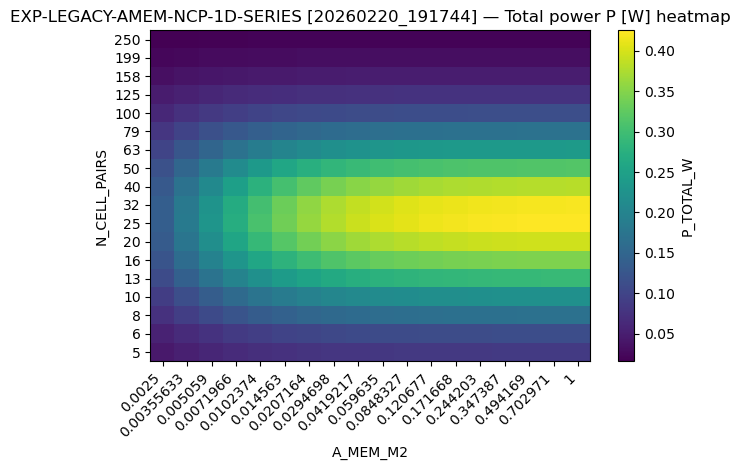

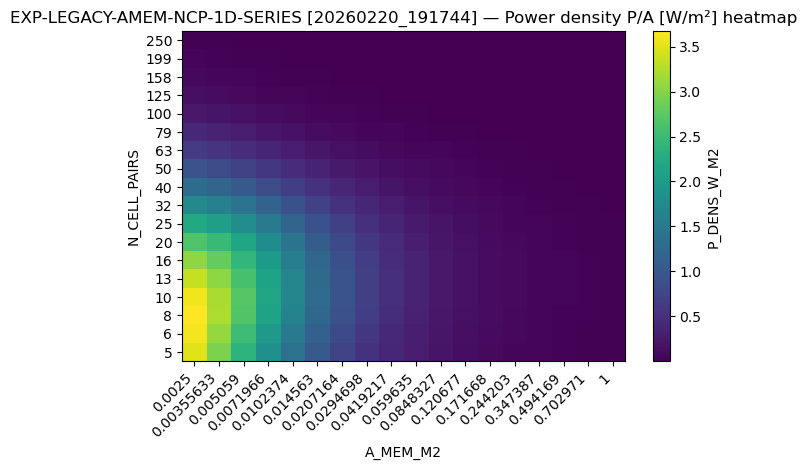

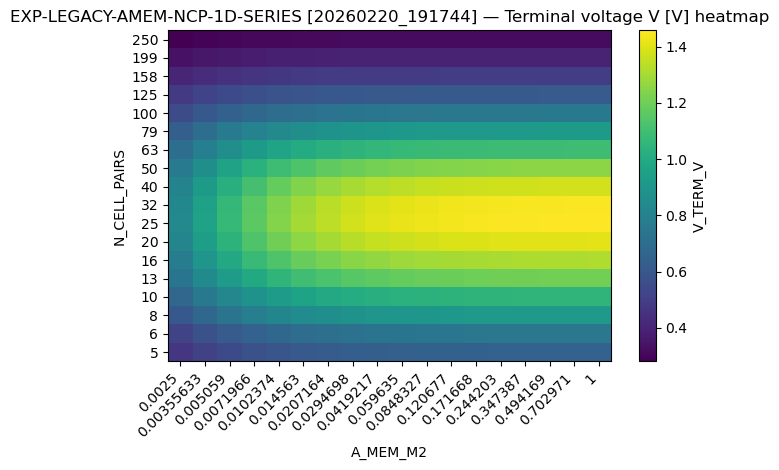

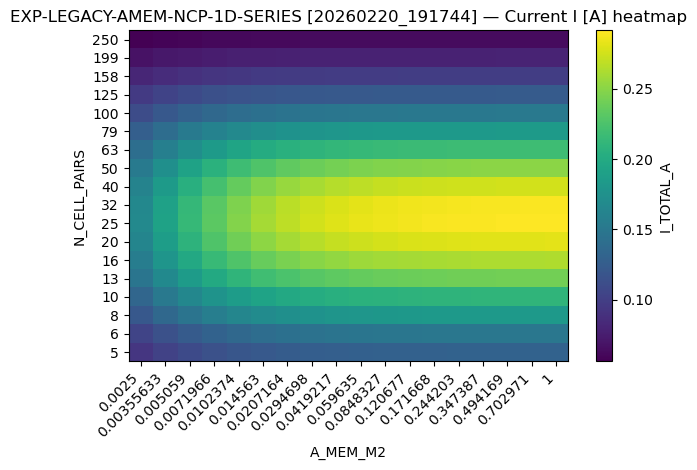

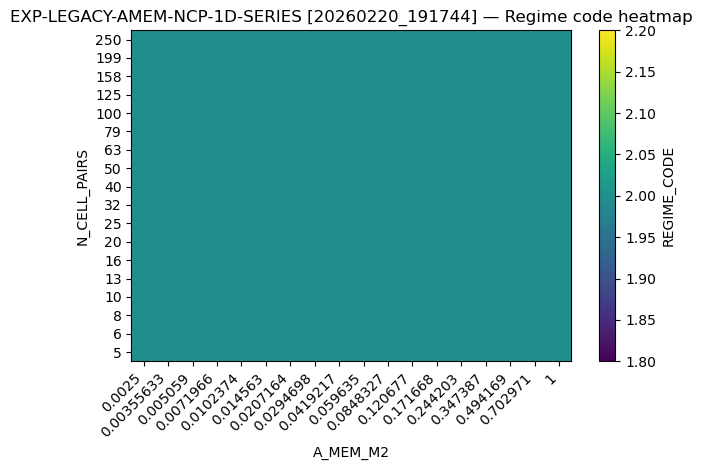

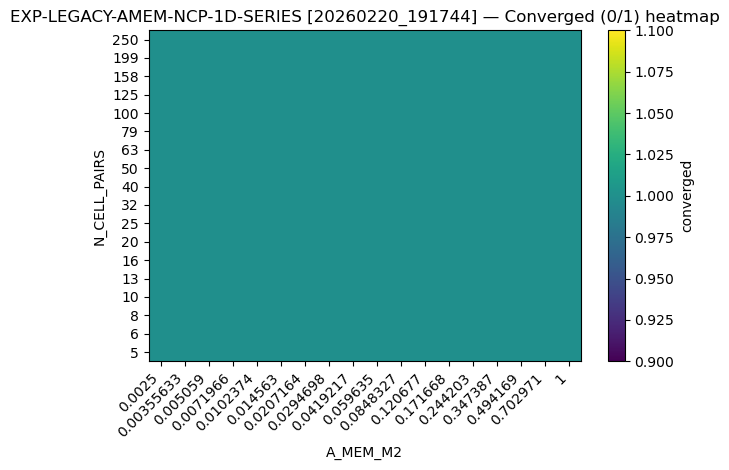

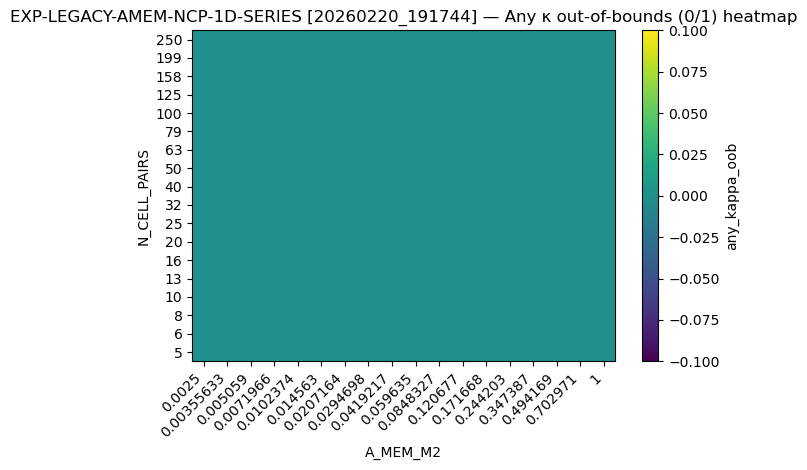

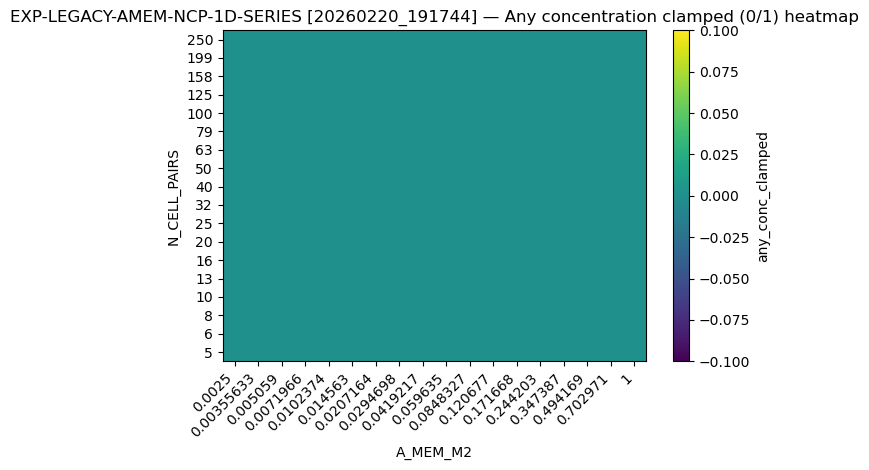

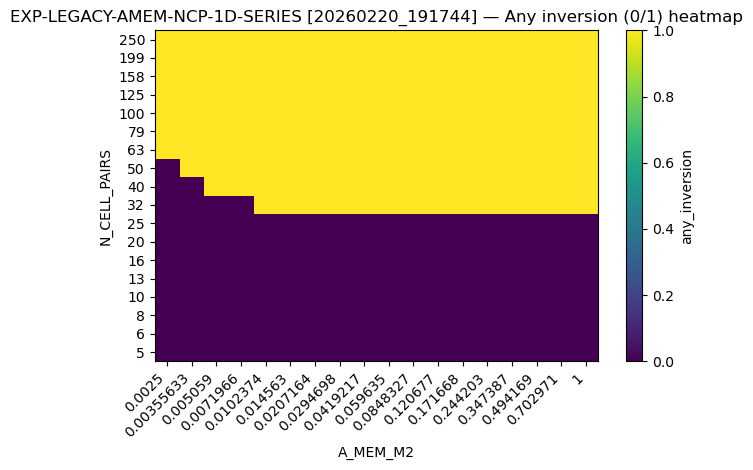

[run_experiment] EXP-LEGACY-AMEM-NCP-1D-SERIES: 324 run(s). Saved under: runs/EXP-LEGACY-AMEM-NCP-1D-SERIES/20260220_191744


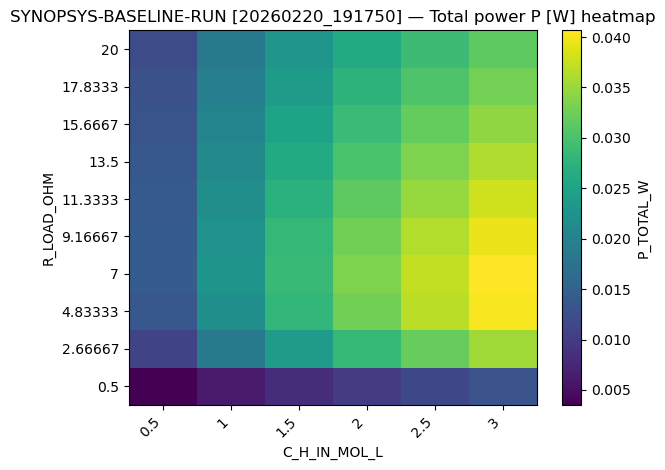

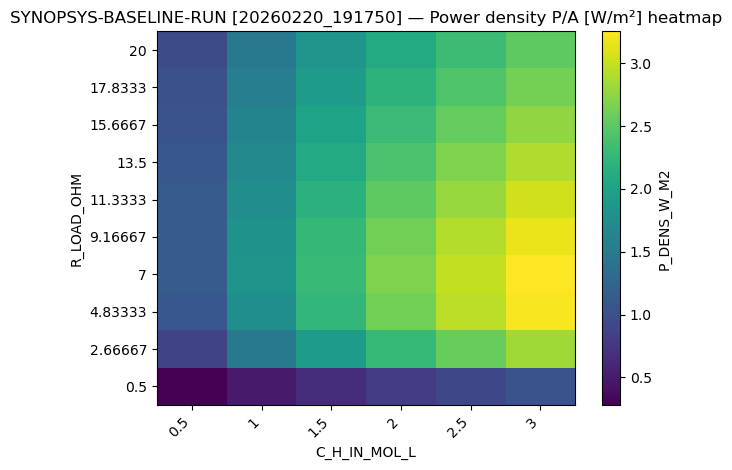

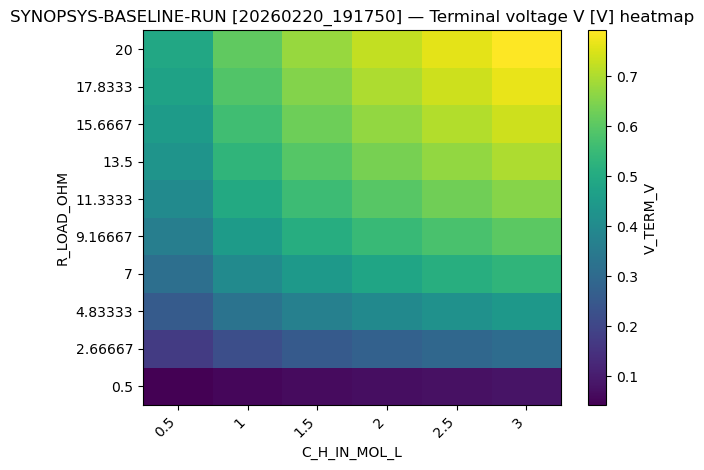

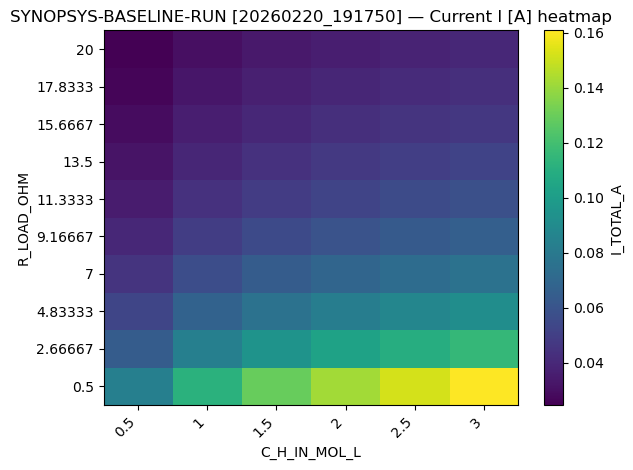

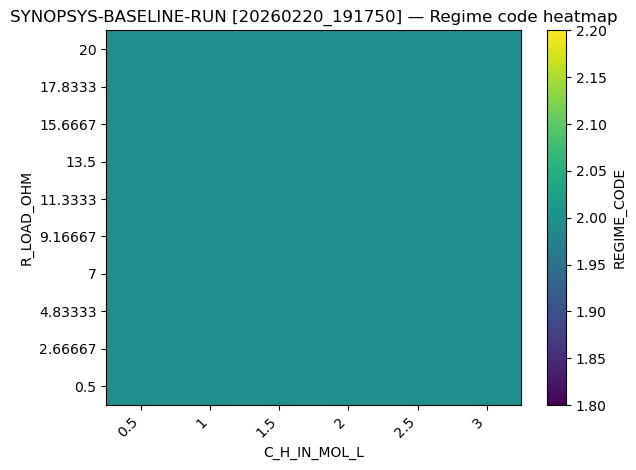

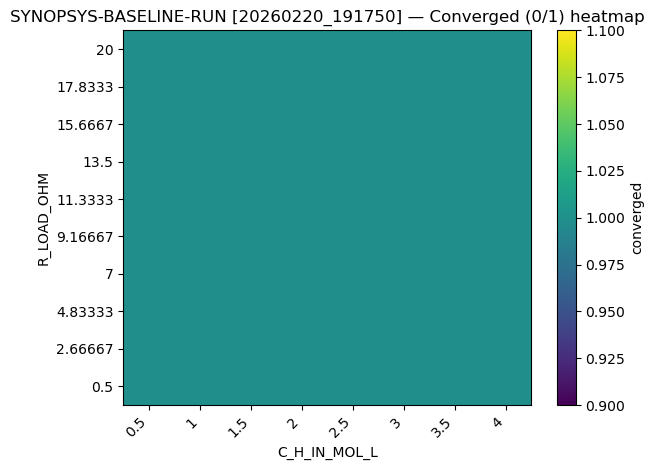

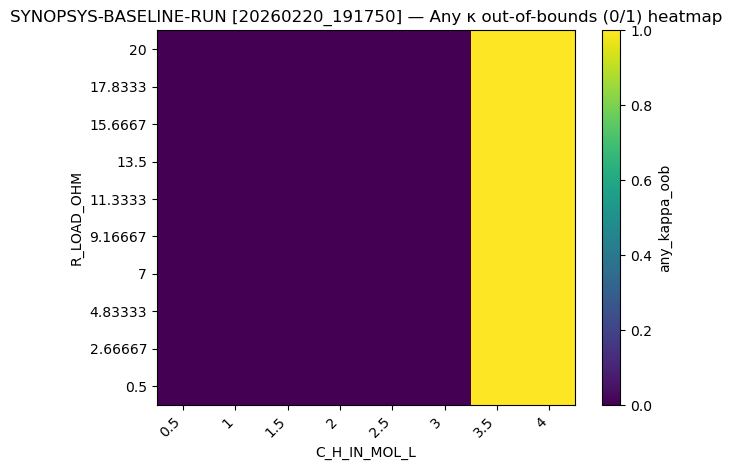

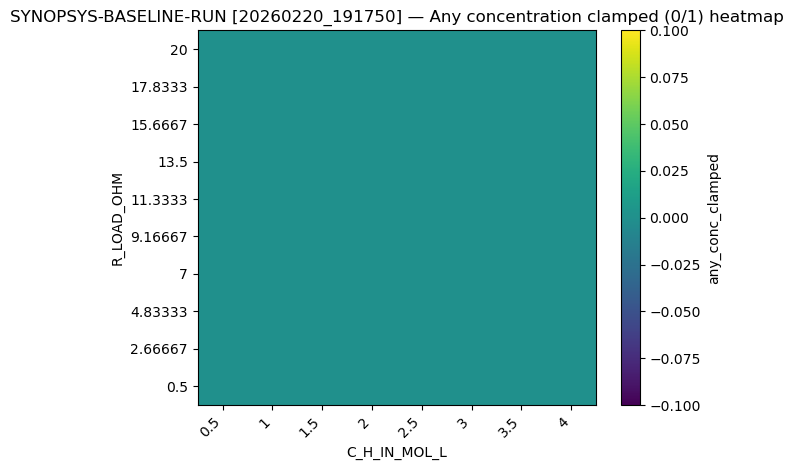

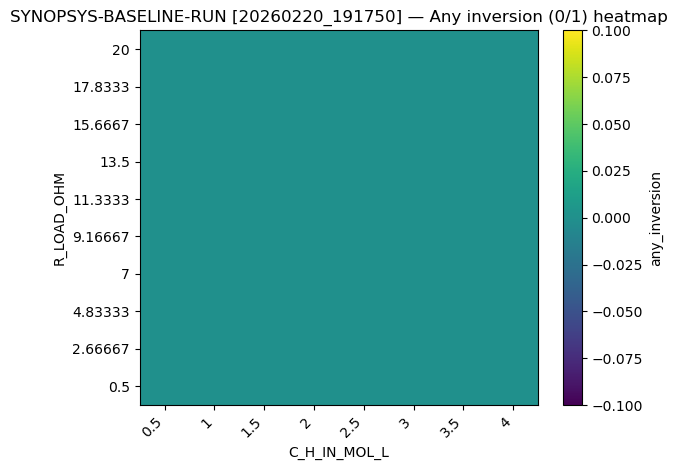

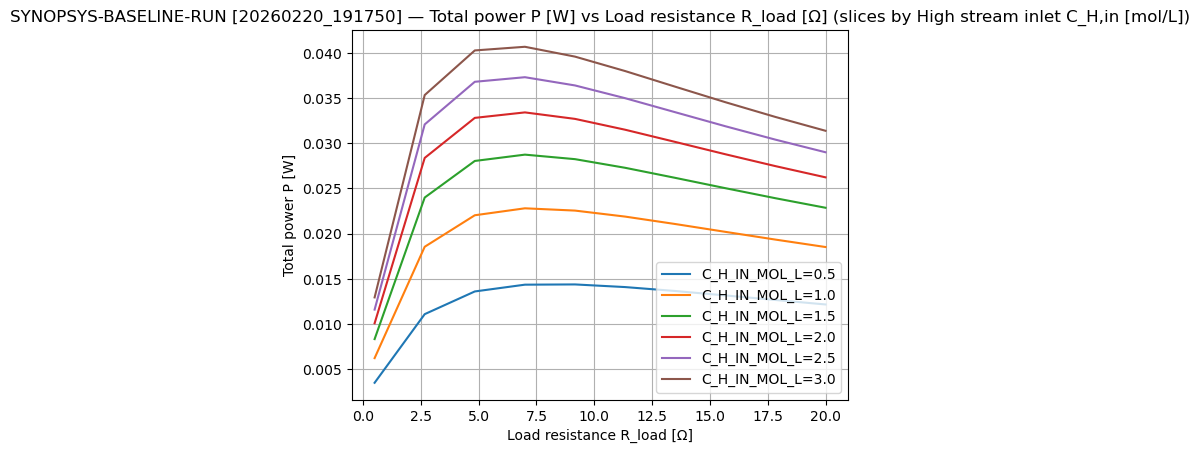

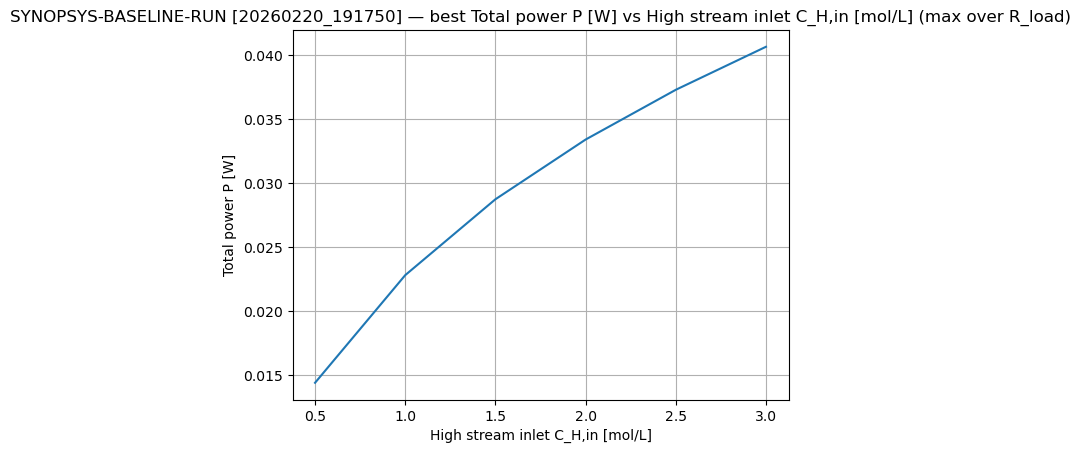

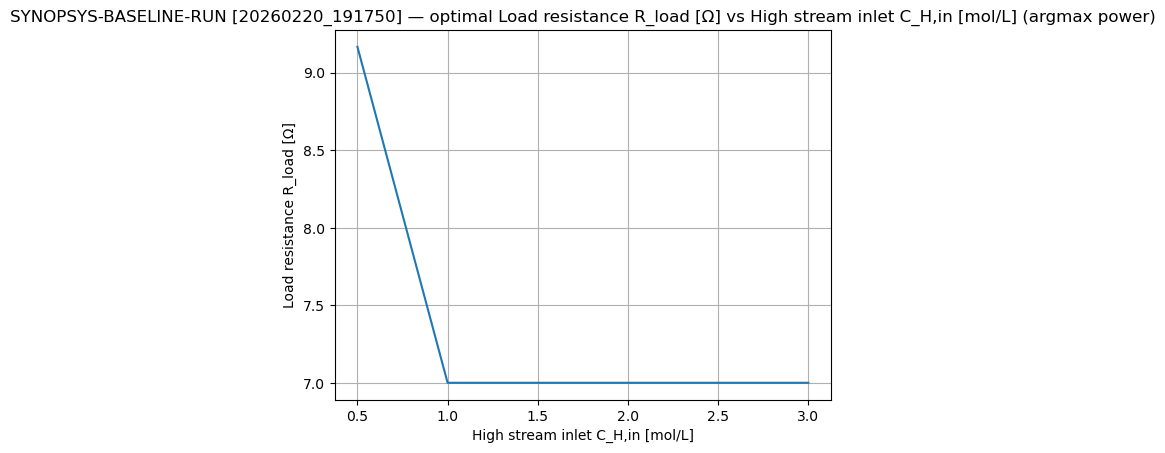

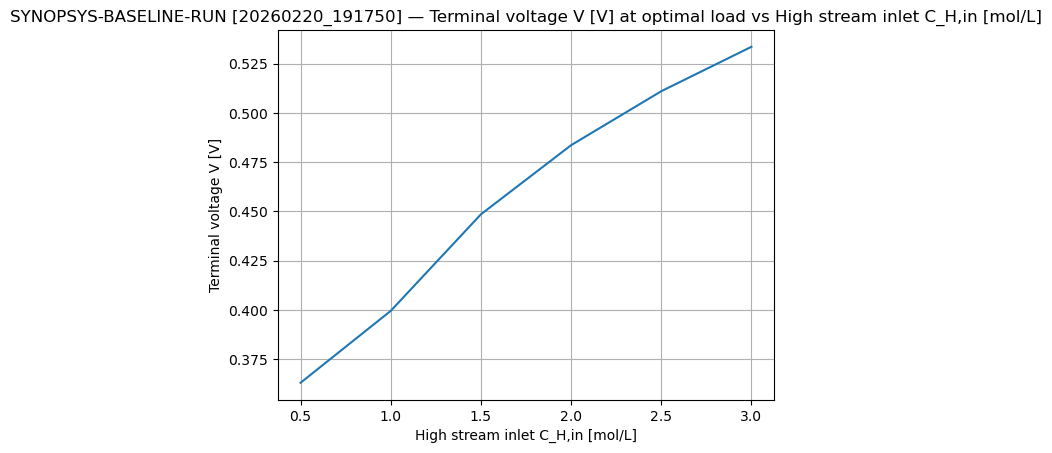

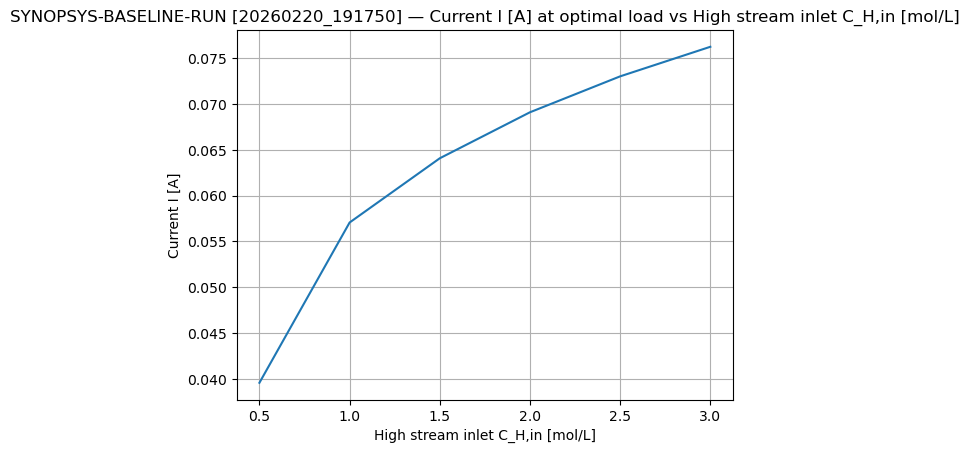

[run_experiment] SYNOPSYS-BASELINE-RUN: 80 run(s). Saved under: runs/SYNOPSYS-BASELINE-RUN/20260220_191750


In [10]:
# -------------------------
# Experiment registry
# -------------------------

def logspace_int(lo: int, hi: int, n: int) -> np.ndarray:
    vals = np.unique(np.round(np.logspace(np.log10(lo), np.log10(hi), n)).astype(int))
    return vals

def logspace_float(lo: float, hi: float, n: int) -> np.ndarray:
    vals = np.logspace(np.log10(lo), np.log10(hi), n).astype(float)
    return vals

# Baseline (control) experiment — match the notebook's current "known good" defaults unless overridden here.
EXPERIMENTS: Dict[str, ExperimentSpec] = {
    "EXP-BASE-001": ExperimentSpec(
        experiment_id="EXP-BASE-001",
        description="Baseline 1D run (control).",
        base_overrides={
            # Keep minimal overrides; rely on DesignInputs defaults unless intentionally changed.
            "MODE": "fixed_load",
        },
        which="1d",
        mode="fixed_load",
        sweep=None,
    ),

    "EXP-SWEEP-001": ExperimentSpec(
        experiment_id="EXP-SWEEP-001",
        description="1D sweep: A_MEM_M2 (membrane area per pair).",
        base_overrides={
            "MODE": "fixed_load",
        },
        which="1d",
        mode="fixed_load",
        sweep=Sweep1D(var="A_MEM_M2", values=logspace_float(0.0025, 1.0, 12)),
        baseline_id="EXP-BASE-001",
    ),

    "EXP-MPPT-001": ExperimentSpec(
        experiment_id="EXP-MPPT-001",
        description="Baseline 1D run with MPPT mode.",
        base_overrides={
            "MODE": "mppt",
        },
        which="1d",
        mode="mppt",
        sweep=None,
        baseline_id="EXP-BASE-001",
    ),

    # Legacy-parity regime maps (disk-first plotting via sweep_table.parquet)
    "EXP-LEGACY-RLOAD-NCP-1D": ExperimentSpec(
        experiment_id="EXP-LEGACY-RLOAD-NCP-1D",
        description="Legacy parity: Power vs R_LOAD_OHM and N_CELL_PAIRS (1D, fixed load).",
        base_overrides={
            "MODE": "fixed_load",
        },
        which="1d",
        mode="fixed_load",
        sweep=Sweep2D(
            var1="R_LOAD_OHM",
            var1_values=np.linspace(0.5, 20.0, 10),
            var2="N_CELL_PAIRS",
            var2_values=np.array([10, 20, 40, 60], dtype=float),
        ),
        baseline_id="EXP-BASE-001",
    ),

    "EXP-LEGACY-RLOAD-NCP-1D-SERIES": ExperimentSpec(
        experiment_id="EXP-LEGACY-RLOAD-NCP-1D-SERIES",
        description="Companion run: same sweep but using the 1d_series solver (for curve-aware debugging).",
        base_overrides={
            "MODE": "fixed_load",
        },
        which="1d_series",
        mode="fixed_load",
        sweep=Sweep2D(
            var1="R_LOAD_OHM",
            var1_values=np.linspace(0.5, 20.0, 10),
            var2="N_CELL_PAIRS",
            var2_values=np.array([10, 20, 40, 60], dtype=float),
        ),
        baseline_id="EXP-BASE-001",
    ),

    "EXP-LEGACY-AMEM-NCP-1D": ExperimentSpec(
        experiment_id="EXP-LEGACY-AMEM-NCP-1D",
        description="Legacy parity: P_DENS + REGIME_CODE vs A_MEM_M2 and N_CELL_PAIRS (1D, fixed load).",
        base_overrides={
            "MODE": "fixed_load",
            "R_LOAD_OHM": 5.0,
            "N_SEG": 30,
        },
        which="1d",
        mode="fixed_load",
        sweep=Sweep2D(
            var1="A_MEM_M2",
            var1_values=logspace_float(0.0025, 1.0, 18),
            var2="N_CELL_PAIRS",
            var2_values=logspace_int(5, 250, 18).astype(float),
        ),
        baseline_id="EXP-BASE-001",
    ),

    "EXP-LEGACY-AMEM-NCP-1D-SERIES": ExperimentSpec(
        experiment_id="EXP-LEGACY-AMEM-NCP-1D-SERIES",
        description="Companion run: same sweep but using the 1d_series solver (for curve-aware debugging).",
        base_overrides={
            "MODE": "fixed_load",
            "R_LOAD_OHM": 5.0,
            "N_SEG": 30,
        },
        which="1d_series",
        mode="fixed_load",
        sweep=Sweep2D(
            var1="A_MEM_M2",
            var1_values=logspace_float(0.0025, 1.0, 18),
            var2="N_CELL_PAIRS",
            var2_values=logspace_int(5, 250, 18).astype(float),
        ),
        baseline_id="EXP-BASE-001",
    ),

    "SYNOPSYS-BASELINE-RUN": ExperimentSpec(
        experiment_id="SYNOPSYS-BASELINE-RUN",
        description="Baseline run with salinity sweep.",
        base_overrides={
            "MODE": "fixed_load",
            "N_SEG": 50,
            "N_CELL_PAIRS": 5,
            "GAP_M": 0.001,
            "A_MEM_M2": 0.0025
        },
        which="1d_series",
        mode="fixed_load",
        sweep=Sweep2D(
            var1="C_H_IN_MOL_L", var1_values=np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]),
            var2="R_LOAD_OHM", var2_values=np.linspace(0.5, 20, 10),
        ),
        baseline_id="EXP-SYNOPSYS-001",
    ),

}

ACTIVE_EXPERIMENT_IDS = [
    "EXP-LEGACY-AMEM-NCP-1D-SERIES",
    "SYNOPSYS-BASELINE-RUN",
]

# Execute the active experiments (disk-first plotting)
_all_bundles = {}
for _eid in ACTIVE_EXPERIMENT_IDS:
    _all_bundles[_eid] = run_experiment(EXPERIMENTS[_eid], make_plots=True, save=True, save_points=False)


## Legacy / scratch experimental cells (preserved)

The cells below are preserved exactly as-is (per instruction) but should be treated as legacy once the harness above becomes the single entry point.


## Validation harness
Runs 2–3 test cases and prints key outputs (OCV, internal resistance, terminal voltage, current, power, outlets).
Replace the test inputs with sheet data and compare manually.

In [ ]:
GLOBAL_MODE = "fixed_load"

def print_key_outputs_0d(res: Dict[str, Any]) -> None:
    print("--- 0D ---")
    for k in ["mode", "E_OCV_V", "R_INT_OHM", "R_LOAD_OHM", "V_TERM_V", "I_A", "P_W", "C_H_OUT_MOL_L", "C_L_OUT_MOL_L"]:
        print(f"{k:>14s}: {res[k]:.6g}" if isinstance(res[k], (int,float,np.floating)) else f"{k:>14s}: {res[k]}")


def print_key_outputs_1d(res: Dict[str, Any]) -> None:
    print("--- 1D axial ---")
    for k in ["mode", "V_OC_EQ_V", "R_INT_EQ_OHM", "R_LOAD_OHM", "V_TERM_V", "I_TOTAL_A", "P_TOTAL_W"]:
        v = res[k]
        print(f"{k:>14s}: {v:.6g}" if isinstance(v, (int,float,np.floating)) else f"{k:>14s}: {v}")
    ps = res["per_segment"]
    print(f"{'C_H_OUT_end':>14s}: {ps['C_H_OUT_MOL_L'][-1]:.6g}")
    print(f"{'C_L_OUT_end':>14s}: {ps['C_L_OUT_MOL_L'][-1]:.6g}")


# --- Test cases (edit to match sheet) ---
base = DesignInputs(
    T_K=298.15,
    N_CELL_PAIRS=20,
    A_MEM_M2=0.5,
    Q_H_M3_S=1.0e-5,
    Q_L_M3_S=1.0e-5,
    C_H_IN_MOL_L=0.5,
    C_L_IN_MOL_L=0.02,
    GAP_M=200e-6,
    ALPHA_PERM=0.9,
    BETA=1.0,
    ASR_AEM_OHM_M2=2.0e-4,
    ASR_CEM_OHM_M2=2.0e-4,
    ASR_EXTRA_OHM_M2=0.0,
    MODE=GLOBAL_MODE,
    R_LOAD_OHM=5.0,
    N_SEG=30,
)

case1 = base
#case2 = clone_params(base, C_L_IN_MOL_L=0.01, R_LOAD_OHM=2.0)
#case3 = clone_params(base, MODE="max_power")  # load chosen automatically

#for i, p in enumerate([case1, case2, case3], start=1):
#    print(f"\n===== CASE {i} =====")
#    r0 = model_0d(p, mode=p.MODE)
#    print_key_outputs_0d(r0)
#    r1 = model_1d_axial(p, mode=p.MODE)
#    print_key_outputs_1d(r1)


## Mini regime-map example
Example sweep over `R_LOAD_OHM` and `N_CELL_PAIRS` (edit ranges as needed).

In [ ]:
spec = SweepSpec(
    var1="R_LOAD_OHM",
    var1_values=np.linspace(0.5, 20.0, 10),
    var2="N_CELL_PAIRS",
    var2_values=np.array([10, 20, 40, 60], dtype=float),
)

df = run_regime_map(
    fixed_params=base_ref,
    sweep_spec=spec,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print(df.head())
heatmap_from_df(df, x="R_LOAD_OHM", y="N_CELL_PAIRS", z="P_TOTAL_W", title="Power vs load and cell pairs (1D)")


In [ ]:
import time, inspect, hashlib, numpy as np

def _sha16_of_source(fn):
    src = inspect.getsource(fn)
    return hashlib.sha256(src.encode("utf-8")).hexdigest()[:16]

def _df_signature(df_, label):
    # stable numeric signature from the sweep outputs
    sig = (
        float(df_["P_TOTAL_W"].sum()),
        float(df_["V_TERM_V"].sum()),
        float(df_["I_TOTAL_A"].sum()),
        float(df_["P_TOTAL_W"].max()),
        float(df_["P_TOTAL_W"].min()),
    )
    print(f"\n[{label}] time={time.time():.3f}")
    print(f"[{label}] rows={len(df_)}  Psum={sig[0]:.9g}  Vsum={sig[1]:.9g}  Isum={sig[2]:.9g}  Pmax={sig[3]:.9g}  Pmin={sig[4]:.9g}")
    print(f"[{label}] df object id={id(df_)}")
    print(f"[{label}] model_1d_axial sha16={_sha16_of_source(model_1d_axial)}")
    print(f"[{label}] _axial_branch_params sha16={_sha16_of_source(_axial_branch_params)}")
    print(f"[{label}] run_regime_map sha16={_sha16_of_source(run_regime_map)}")

# call one of these depending on location
# after df creation:
_df_signature(df, "DF")

# after df_ref creation:
# _df_signature(df_ref, "DF_REF")

In [ ]:
# -------------------------
# Wide-but-structured log sweep (2D): A_MEM_M2 vs N_CELL_PAIRS
# -------------------------

def logspace_int(lo: int, hi: int, n: int) -> np.ndarray:
    vals = np.unique(np.round(np.logspace(np.log10(lo), np.log10(hi), n)).astype(int))
    return vals

def logspace_float(lo: float, hi: float, n: int) -> np.ndarray:
    return np.logspace(np.log10(lo), np.log10(hi), n)

N_vals = logspace_int(5, 250, 18)
A_vals = logspace_float(0.0025, 1.0, 18)

spec_NA = SweepSpec(
    var1="A_MEM_M2",
    var1_values=A_vals,
    var2="N_CELL_PAIRS",
    var2_values=N_vals.astype(float),
)

# Fixed-load sweep to reveal blocked/partial/conducting regimes
baseline_fixed_load = clone_params(base_ref, MODE="fixed_load", R_LOAD_OHM=5.0, N_SEG=30)

df_NA = run_regime_map(
    fixed_params=baseline_fixed_load,
    sweep_spec=spec_NA,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print("Rows:", len(df_NA))
print(df_NA[["A_MEM_M2","N_CELL_PAIRS","P_TOTAL_W","P_DENS_W_M2","regime","converged","any_kappa_oob","any_conc_clamped","any_inversion"]].head())

# Filter to reliable points (adjust filters depending on what you want to visualize)
df_ok = df_NA.copy()
df_ok = df_ok[df_ok["converged"] == True]
df_ok = df_ok[df_ok["any_kappa_oob"] == False]

heatmap_from_df(df_ok, x="A_MEM_M2", y="N_CELL_PAIRS", z="P_DENS_W_M2",
                title="Power density (W/m²) vs area per pair and cell pairs (1D, fixed load)")

heatmap_from_df(df_ok, x="A_MEM_M2", y="N_CELL_PAIRS", z="REGIME_CODE",
                title="Regime map: 0=blocked, 1=partial, 2=conducting")


In [ ]:
GLOBAL_MODE = "fixed_load"

# -------------------------
# Restored legacy line plots (regression / sanity check)
# -------------------------
# NOTE: This cell intentionally duplicates earlier plots so historical
# visual checks remain available. No prior code or comments were removed.

import matplotlib.pyplot as plt

try:
    base
except NameError:
    base = DesignInputs()

def _with_updates(p: DesignInputs, **kw) -> DesignInputs:
    return replace(p, **kw)

# Power vs load — 1D axial, NO fouling (legacy baseline)
R_loads = np.linspace(0.5, 20.0, 60)
try:
    p_nf = _with_updates(base, FOULING_MODEL='none')
except TypeError:
    # Backward compatibility if DesignInputs in this run doesn't include FOULING_MODEL
    p_nf = base

P_nf = []
for R in R_loads:
    P_nf.append(
        model_1d_axial(_with_updates(p_nf, R_LOAD_OHM=float(R)), mode='fixed_load')['P_TOTAL_W']
    )

plt.figure()
plt.plot(R_loads, P_nf)
plt.title('Power vs Load (1D axial) — legacy no-fouling baseline')
plt.xlabel('Load resistance [Ω]')
plt.ylabel('Total power [W]')
plt.show()

# Axial salinity profile — 1D axial, NO fouling (legacy baseline)
res_nf = model_1d_axial(p_nf, mode='fixed_load')
x = np.arange(int(p_nf.N_SEG), dtype=float)

plt.figure()
plt.plot(x, res_nf['per_segment']['C_H_IN_MOL_L'], label='C_H in')
plt.plot(x, res_nf['per_segment']['C_H_OUT_MOL_L'], label='C_H out')
plt.title('High-stream salinity vs axial segment — legacy no fouling')
plt.xlabel('Axial segment index')
plt.ylabel('Concentration [mol/L]')
plt.legend()
plt.show()


# -------------------------
# NEW: Standard series-current 1D axial plots (single electrode pair)
# -------------------------

# Power vs load — 1D axial series-current, NO fouling (Tier A baseline)
P_sc = []
for R in R_loads:
    P_sc.append(
        model_1d_axial_series_current(_with_updates(p_nf, R_LOAD_OHM=float(R)), mode='fixed_load')['P_TOTAL_W']
    )

plt.figure()
plt.plot(R_loads, P_sc)
plt.title('Power vs Load (1D axial, series-current) — Tier A no-fouling baseline')
plt.xlabel('Load resistance [Ω]')
plt.ylabel('Total power [W]')
plt.show()

# Axial salinity profile — 1D axial series-current, NO fouling (Tier A baseline)
res_sc = model_1d_axial_series_current(p_nf, mode='fixed_load')
x = np.arange(int(p_nf.N_SEG), dtype=float)

plt.figure()
plt.plot(x, res_sc['per_segment']['C_H_IN_MOL_L'], label='C_H in')
plt.plot(x, res_sc['per_segment']['C_H_OUT_MOL_L'], label='C_H out')
plt.title('High-stream salinity vs axial segment — series-current no fouling')
plt.xlabel('Axial segment index')
plt.ylabel('Concentration [mol/L]')
plt.legend()
plt.show()


In [ ]:
GLOBAL_MODE = "fixed_load"

# -------------------------
# REFERENCE CHECK CELL
# Power vs load and cell pairs (1D) — baseline reproduction
# -------------------------

# This cell is intentionally minimal and mirrors the known-good sweep.
# Purpose: verify that the current code reproduces the historical map exactly.

# Defensive: ensure we have a baseline parameter object
try:
    base_ref = base
except NameError:
    base_ref = DesignInputs()

# Sweep definition (REFERENCE)
spec_ref = SweepSpec(
    var1="R_LOAD_OHM",
    var1_values=np.linspace(0.5, 20.0, 10),
    var2="N_CELL_PAIRS",
    var2_values=np.array([10, 20, 40, 60], dtype=float),
)

# IMPORTANT:
#  - fixed_load mode
#  - 1D model
#  - NO fouling (baseline check)
try:
    base_ref = replace(base_ref, FOULING_MODEL="none")
except TypeError:
    # Backward safety: if FOULING_MODEL is not present for some reason
    base_ref = base_ref


# ---- HARD RESET FOR SWEEPS (baseline) ----
GLOBAL_MODE = "fixed_load"




df_ref = run_regime_map(
    fixed_params=base_ref,
    sweep_spec=spec_ref,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print("Reference sweep rows:", len(df_ref))
print(df_ref[["R_LOAD_OHM", "N_CELL_PAIRS", "P_TOTAL_W", "regime", "converged"]].head())

# Reference power heatmap
heatmap_from_df(
    df_ref,
    x="R_LOAD_OHM",
    y="N_CELL_PAIRS",
    z="P_TOTAL_W",
    title="Power vs load and cell pairs (1D) — reference baseline"
)


In [ ]:
# -------------------------
# PARITY TEST (legacy vs harness parquet)
# -------------------------
# Goal: prove harness sweep_table.parquet matches legacy regime map outputs
# for the SAME baseline and SAME sweep grid.

import json
import pandas as pd
import numpy as np
from pathlib import Path


def _get_sweep_parquet_path(env: dict, run_dir: Path) -> Path:
    # Preferred: JSON envelope explicitly points to parquet under env["artifacts"]["sweep_table"]
    artifacts = env.get("artifacts") or {}
    name = artifacts.get("sweep_table") or artifacts.get("sweep_table_parquet") or artifacts.get("table")
    if isinstance(name, str) and name.endswith(".parquet"):
        p = run_dir / name
        if p.exists():
            return p

    # Fallback: look for a single parquet file in the run directory
    cands = sorted(run_dir.glob("*.parquet"))
    if len(cands) == 1:
        return cands[0]

    # Next fallback: prefer a file named like sweep_table*.parquet
    cands2 = sorted(run_dir.glob("sweep_table*.parquet"))
    if cands2:
        return cands2[0]

    raise KeyError("Could not locate sweep parquet file; JSON has no artifacts['sweep_table'] and no suitable *.parquet found.")

def _assert_same_grid(df_a: pd.DataFrame, df_b: pd.DataFrame, keys):
    a = df_a[keys].drop_duplicates().sort_values(keys).reset_index(drop=True)
    b = df_b[keys].drop_duplicates().sort_values(keys).reset_index(drop=True)
    if len(a) != len(b) or not (a.values == b.values).all():
        raise AssertionError("Grid mismatch between legacy and harness outputs.")

def _compare_frames(df_legacy: pd.DataFrame, df_new: pd.DataFrame, keys, cols_float, cols_exact, atol=1e-9, rtol=1e-9):
    _assert_same_grid(df_legacy, df_new, keys)

    dl = df_legacy.sort_values(keys).reset_index(drop=True)
    dn = df_new.sort_values(keys).reset_index(drop=True)

    for c in cols_exact:
        if c not in dl.columns or c not in dn.columns:
            raise AssertionError(f"Missing exact column in one frame: {c}")
        if not (dl[c].values == dn[c].values).all():
            idx = np.where(dl[c].values != dn[c].values)[0][0]
            raise AssertionError(f"Exact mismatch in {c} at row {idx}: legacy={dl[c].iloc[idx]} new={dn[c].iloc[idx]}")

    for c in cols_float:
        if c not in dl.columns or c not in dn.columns:
            raise AssertionError(f"Missing float column in one frame: {c}")
        a = dl[c].astype(float).values
        b = dn[c].astype(float).values
        if not np.allclose(a, b, atol=atol, rtol=rtol, equal_nan=True):
            diffs = np.abs(a - b)
            idx = int(np.nanargmax(diffs))
            raise AssertionError(f"Float mismatch in {c} at row {idx}: legacy={dl[c].iloc[idx]} new={dn[c].iloc[idx]} |diff|={diffs[idx]}")

# --- Legacy run ---
spec_legacy = Sweep2D(var1="R_LOAD_OHM", var1_values=R_LOAD_vals_legacy, var2="N_CELL_PAIRS", var2_values=N_vals_legacy)

df_legacy_1d = run_regime_map(
    fixed_params=base_ref,
    sweep_spec=spec_legacy,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

# --- Harness run (writes parquet) ---
base_overrides = {k: getattr(base_ref, k) for k in DesignInputs.__dataclass_fields__.keys()}

spec_harness_1d = ExperimentSpec(
    experiment_id="EXP-PARITY-1D",
    description="parity check: R_LOAD_OHM x N_CELL_PAIRS (which=1d)",
    base_overrides=base_overrides,
    which="1d",
    mode="fixed_load",
    sweep=Sweep2D(var1="R_LOAD_OHM", var1_values=R_LOAD_vals_legacy, var2="N_CELL_PAIRS", var2_values=N_vals_legacy),
)

_ = run_experiment(spec_harness_1d, make_plots=False, save=True, save_points=False)

run_root = Path("runs") / spec_harness_1d.experiment_id
latest_run = sorted([p for p in run_root.iterdir() if p.is_dir()])[-1]

with open(latest_run / "run_bundle.json", "r", encoding="utf-8") as f:
    env = json.load(f)

df_new_1d = pd.read_parquet(_get_sweep_parquet_path(env, latest_run))

keys = ["R_LOAD_OHM", "N_CELL_PAIRS"]
cols_exact = ["REGIME_CODE"]
cols_float = ["P_TOTAL_W", "P_DENS_W_M2", "A_TOTAL_MEM_M2"]


coord = (
    (df_legacy_1d["R_LOAD_OHM"] == 0.5) &
    (df_legacy_1d["N_CELL_PAIRS"] == 60)
)

print("legacy P_TOTAL_W:",
      df_legacy_1d.loc[coord, "P_TOTAL_W"].values)

print("new P_TOTAL_W:",
      df_new_1d.loc[
          (df_new_1d["R_LOAD_OHM"] == 0.5) &
          (df_new_1d["N_CELL_PAIRS"] == 60),
          "P_TOTAL_W"
      ].values)

print("ratio (new / legacy):",
      df_new_1d.loc[
          (df_new_1d["R_LOAD_OHM"] == 0.5) &
          (df_new_1d["N_CELL_PAIRS"] == 60),
          "P_TOTAL_W"
      ].values
      /
      df_legacy_1d.loc[coord, "P_TOTAL_W"].values)



_compare_frames(df_legacy_1d, df_new_1d, keys, cols_float, cols_exact)

print("[parity] PASS: which=1d parquet matches legacy regime map for required columns.")

# --- Repeat for 1d_series ---
df_legacy_series = run_regime_map(
    fixed_params=base_ref,
    sweep_spec=spec_legacy,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d_series",
    mode="fixed_load",
)

spec_harness_series = ExperimentSpec(
    experiment_id="EXP-PARITY-1D-SERIES",
    description="parity check: R_LOAD_OHM x N_CELL_PAIRS (which=1d_series)",
    base_overrides=base_overrides,
    which="1d_series",
    mode="fixed_load",
    sweep=Sweep2D(var1="R_LOAD_OHM", var1_values=R_LOAD_vals_legacy, var2="N_CELL_PAIRS", var2_values=N_vals_legacy),
)

_ = run_experiment(spec_harness_series, make_plots=False, save=True, save_points=False)

run_root2 = Path("runs") / spec_harness_series.experiment_id
latest_run2 = sorted([p for p in run_root2.iterdir() if p.is_dir()])[-1]

with open(latest_run2 / "run_bundle.json", "r", encoding="utf-8") as f:
    env2 = json.load(f)

df_new_series = pd.read_parquet(_get_sweep_parquet_path(env2, latest_run2))

_compare_frames(df_legacy_series, df_new_series, keys, cols_float, cols_exact)

print("[parity] PASS: which=1d_series parquet matches legacy regime map for required columns.")


## Harness mirror experiments (legacy-parity)

These cells run **new harness experiments** that mirror the legacy `run_regime_map` experiments exactly (same sweep grids and same baseline values), then recreate the same heatmaps by plotting **purely from disk** (parquet-backed).

In [ ]:
# -------------------------
# Harness mirror: shared helpers (disk-only plotting)
# -------------------------
import json
import pandas as pd
from pathlib import Path

def _latest_run_dir(experiment_id: str) -> Path:
    root = Path("runs") / experiment_id
    dirs = sorted([p for p in root.iterdir() if p.is_dir()])
    if not dirs:
        raise FileNotFoundError(f"No run dirs found under {root}")
    return dirs[-1]

def _load_env_and_table(run_dir: Path):
    with open(run_dir / "run_bundle.json", "r", encoding="utf-8") as f:
        env = json.load(f)
    # prefer explicit pointer, otherwise fall back to search
    artifacts = env.get("artifacts") or {}
    name = artifacts.get("sweep_table") or artifacts.get("sweep_table_parquet") or artifacts.get("table")
    if isinstance(name, str) and name.endswith(".parquet") and (run_dir / name).exists():
        pq = run_dir / name
    else:
        cands = sorted(run_dir.glob("sweep_table*.parquet"))
        if cands:
            pq = cands[0]
        else:
            cands = sorted(run_dir.glob("*.parquet"))
            if len(cands) == 1:
                pq = cands[0]
            else:
                raise KeyError("Could not locate sweep parquet file in run directory.")
    df = pd.read_parquet(pq)
    return env, df, pq


In [ ]:
# -------------------------
# EXPERIMENT 1 (legacy) — harness mirror
# Power vs load and cell pairs (1D, fixed load)
# -------------------------
GLOBAL_MODE = "fixed_load"

spec_exp1 = SweepSpec(
    var1="R_LOAD_OHM",
    var1_values=np.linspace(0.5, 20.0, 10),
    var2="N_CELL_PAIRS",
    var2_values=np.array([10, 20, 40, 60], dtype=float),
)

# Legacy baseline: fixed_params=base
try:
    base_legacy = base
except NameError:
    base_legacy = DesignInputs()

# Convert baseline DesignInputs -> base_overrides dict (field-for-field)
base_overrides_exp1 = {k: getattr(base_legacy, k) for k in DesignInputs.__dataclass_fields__.keys()}

spec_h_exp1 = ExperimentSpec(
    experiment_id="EXP-MIRROR-001",
    description="Mirror of legacy Experiment 1: R_LOAD_OHM x N_CELL_PAIRS (which=1d, fixed_load) using baseline 'base'.",
    base_overrides=base_overrides_exp1,
    which="1d",
    mode="fixed_load",
    sweep=Sweep2D(var1="R_LOAD_OHM", var1_values=spec_exp1.var1_values, var2="N_CELL_PAIRS", var2_values=spec_exp1.var2_values),
)

_ = run_experiment(spec_h_exp1, make_plots=False, save=True, save_points=False)

run_dir = _latest_run_dir(spec_h_exp1.experiment_id)
env, df_exp1, pq = _load_env_and_table(run_dir)

print("[EXP1] run_dir:", run_dir)
print("[EXP1] parquet:", pq)
print("[EXP1] rows:", len(df_exp1))
print(df_exp1[["R_LOAD_OHM", "N_CELL_PAIRS", "P_TOTAL_W", "regime", "converged"]].head())

heatmap_from_df(df_exp1, x="R_LOAD_OHM", y="N_CELL_PAIRS", z="P_TOTAL_W",
                title="Power vs load and cell pairs (disk, parquet-backed) — EXP1 mirror")


In [ ]:
# -------------------------
# EXPERIMENT 3 (legacy reference) — harness mirror
# Power vs load and cell pairs (1D) — reference baseline reproduction
# -------------------------
GLOBAL_MODE = "fixed_load"

spec_ref = SweepSpec(
    var1="R_LOAD_OHM",
    var1_values=np.linspace(0.5, 20.0, 10),
    var2="N_CELL_PAIRS",
    var2_values=np.array([10, 20, 40, 60], dtype=float),
)

# Exact legacy reference baseline (hard reset)
base_ref_nf = DesignInputs(
    T_K=298.15,
    N_CELL_PAIRS=20,
    A_MEM_M2=0.5,
    Q_H_M3_S=1.0e-5,
    Q_L_M3_S=1.0e-5,
    C_H_IN_MOL_L=0.5,
    C_L_IN_MOL_L=0.02,
    GAP_M=200e-6,
    ALPHA_PERM=0.9,
    BETA=1.0,
    ASR_AEM_OHM_M2=2.0e-4,
    ASR_CEM_OHM_M2=2.0e-4,
    ASR_EXTRA_OHM_M2=0.0,
    MODE="fixed_load",
    R_LOAD_OHM=5.0,
    N_SEG=30,
    FOULING_MODEL="none",
)

base_overrides_exp3 = {k: getattr(base_ref_nf, k) for k in DesignInputs.__dataclass_fields__.keys()}

spec_h_exp3 = ExperimentSpec(
    experiment_id="EXP-MIRROR-003",
    description="Mirror of legacy Experiment 3 reference baseline: R_LOAD_OHM x N_CELL_PAIRS (which=1d, fixed_load) using hard-reset base_ref_nf.",
    base_overrides=base_overrides_exp3,
    which="1d",
    mode="fixed_load",
    sweep=Sweep2D(var1="R_LOAD_OHM", var1_values=spec_ref.var1_values, var2="N_CELL_PAIRS", var2_values=spec_ref.var2_values),
)

_ = run_experiment(spec_h_exp3, make_plots=False, save=True, save_points=False)

run_dir = _latest_run_dir(spec_h_exp3.experiment_id)
env, df_exp3, pq = _load_env_and_table(run_dir)

print("[EXP3] run_dir:", run_dir)
print("[EXP3] parquet:", pq)
print("[EXP3] rows:", len(df_exp3))
print(df_exp3[["R_LOAD_OHM", "N_CELL_PAIRS", "P_TOTAL_W", "regime", "converged"]].head())

heatmap_from_df(df_exp3, x="R_LOAD_OHM", y="N_CELL_PAIRS", z="P_TOTAL_W",
                title="Power vs load and cell pairs (1D) — reference baseline (disk mirror EXP3)")


In [ ]:
# -------------------------
# EXPERIMENT 2 (legacy) — harness mirror
# Wide-but-structured log sweep (2D): A_MEM_M2 vs N_CELL_PAIRS (1D, fixed load)
# -------------------------
GLOBAL_MODE = "fixed_load"

def logspace_int(lo: int, hi: int, n: int) -> np.ndarray:
    vals = np.unique(np.round(np.logspace(np.log10(lo), np.log10(hi), n)).astype(int))
    return vals

def logspace_float(lo: float, hi: float, n: int) -> np.ndarray:
    return np.logspace(np.log10(lo), np.log10(hi), n)

N_vals = logspace_int(5, 250, 18)
A_vals = logspace_float(0.0025, 1.0, 18)

spec_NA = SweepSpec(
    var1="A_MEM_M2",
    var1_values=A_vals,
    var2="N_CELL_PAIRS",
    var2_values=N_vals.astype(float),
)

# Legacy baseline: baseline_fixed_load = clone_params(base, MODE="fixed_load", R_LOAD_OHM=5.0, N_SEG=30)
try:
    base_legacy = base
except NameError:
    base_legacy = DesignInputs()

baseline_fixed_load = clone_params(base_legacy, MODE="fixed_load", R_LOAD_OHM=5.0, N_SEG=30)

base_overrides_exp2 = {k: getattr(baseline_fixed_load, k) for k in DesignInputs.__dataclass_fields__.keys()}

spec_h_exp2 = ExperimentSpec(
    experiment_id="EXP-MIRROR-002",
    description="Mirror of legacy Experiment 2: A_MEM_M2 x N_CELL_PAIRS (which=1d, fixed_load) using baseline_fixed_load from clone_params(base,...).",
    base_overrides=base_overrides_exp2,
    which="1d",
    mode="fixed_load",
    sweep=Sweep2D(var1="A_MEM_M2", var1_values=spec_NA.var1_values, var2="N_CELL_PAIRS", var2_values=spec_NA.var2_values),
)

_ = run_experiment(spec_h_exp2, make_plots=False, save=True, save_points=False)

run_dir = _latest_run_dir(spec_h_exp2.experiment_id)
env, df_exp2, pq = _load_env_and_table(run_dir)

print("[EXP2] run_dir:", run_dir)
print("[EXP2] parquet:", pq)
print("[EXP2] rows:", len(df_exp2))

# Match legacy filtering
df_ok = df_exp2.copy()
if "converged" in df_ok.columns:
    df_ok = df_ok[df_ok["converged"] == True]
if "any_kappa_oob" in df_ok.columns:
    df_ok = df_ok[df_ok["any_kappa_oob"] == False]

print(df_ok[["A_MEM_M2","N_CELL_PAIRS","P_TOTAL_W","P_DENS_W_M2","regime","converged","any_kappa_oob","any_conc_clamped","any_inversion"]].head())

heatmap_from_df(df_ok, x="A_MEM_M2", y="N_CELL_PAIRS", z="P_DENS_W_M2",
                title="Power density (W/m²) vs area per pair and cell pairs (disk mirror EXP2)")

heatmap_from_df(df_ok, x="A_MEM_M2", y="N_CELL_PAIRS", z="REGIME_CODE",
                title="Regime map: 0=blocked, 1=partial, 2=conducting (disk mirror EXP2)")


In [ ]:
# -------------------------
# Optional: run BOTH 1D models (which="1d_series") for EXP1 and EXP3 mirrors
# -------------------------
GLOBAL_MODE = "fixed_load"

# EXP1 series
spec_h_exp1_series = ExperimentSpec(
    experiment_id="EXP-MIRROR-001-SERIES",
    description="EXP1 mirror using which=1d_series.",
    base_overrides=base_overrides_exp1,
    which="1d_series",
    mode="fixed_load",
    sweep=Sweep2D(var1="R_LOAD_OHM", var1_values=spec_exp1.var1_values, var2="N_CELL_PAIRS", var2_values=spec_exp1.var2_values),
)
_ = run_experiment(spec_h_exp1_series, make_plots=False, save=True, save_points=False)
run_dir = _latest_run_dir(spec_h_exp1_series.experiment_id)
_, df_exp1s, pq = _load_env_and_table(run_dir)
print("[EXP1 series] rows:", len(df_exp1s))
heatmap_from_df(df_exp1s, x="R_LOAD_OHM", y="N_CELL_PAIRS", z="P_TOTAL_W",
                title="Power vs load and cell pairs (disk, parquet-backed) — EXP1 mirror (1d_series)")

# EXP3 series
spec_h_exp3_series = ExperimentSpec(
    experiment_id="EXP-MIRROR-003-SERIES",
    description="EXP3 reference mirror using which=1d_series.",
    base_overrides=base_overrides_exp3,
    which="1d_series",
    mode="fixed_load",
    sweep=Sweep2D(var1="R_LOAD_OHM", var1_values=spec_ref.var1_values, var2="N_CELL_PAIRS", var2_values=spec_ref.var2_values),
)
_ = run_experiment(spec_h_exp3_series, make_plots=False, save=True, save_points=False)
run_dir = _latest_run_dir(spec_h_exp3_series.experiment_id)
_, df_exp3s, pq = _load_env_and_table(run_dir)
print("[EXP3 series] rows:", len(df_exp3s))
heatmap_from_df(df_exp3s, x="R_LOAD_OHM", y="N_CELL_PAIRS", z="P_TOTAL_W",
                title="Power vs load and cell pairs (disk) — EXP3 reference mirror (1d_series)")


In [ ]:
import time, inspect, hashlib, numpy as np

def _sha16_of_source(fn):
    src = inspect.getsource(fn)
    return hashlib.sha256(src.encode("utf-8")).hexdigest()[:16]

def _df_signature(df_, label):
    # stable numeric signature from the sweep outputs
    sig = (
        float(df_["P_TOTAL_W"].sum()),
        float(df_["V_TERM_V"].sum()),
        float(df_["I_TOTAL_A"].sum()),
        float(df_["P_TOTAL_W"].max()),
        float(df_["P_TOTAL_W"].min()),
    )
    print(f"\n[{label}] time={time.time():.3f}")
    print(f"[{label}] rows={len(df_)}  Psum={sig[0]:.9g}  Vsum={sig[1]:.9g}  Isum={sig[2]:.9g}  Pmax={sig[3]:.9g}  Pmin={sig[4]:.9g}")
    print(f"[{label}] df object id={id(df_)}")
    print(f"[{label}] model_1d_axial sha16={_sha16_of_source(model_1d_axial)}")
    print(f"[{label}] _axial_branch_params sha16={_sha16_of_source(_axial_branch_params)}")
    print(f"[{label}] run_regime_map sha16={_sha16_of_source(run_regime_map)}")

# call one of these depending on location
# after df creation:
_df_signature(df, "DF")

# after df_ref creation:
# _df_signature(df_ref, "DF_REF")

In [ ]:
GLOBAL_MODE = "fixed_load"

# Convention sanity check (non-fatal)
# This cell does NOT change results; it only prints warnings if conventions drift.

try:
    p_chk = base
except NameError:
    p_chk = DesignInputs()

A_stack = p_chk.A_MEM_M2 * p_chk.N_CELL_PAIRS
if A_stack <= 0:
    print('WARNING: Total membrane area is non-positive')

if p_chk.Q_H_M3_S < 1e-8 or p_chk.Q_L_M3_S < 1e-8:
    print('NOTE: Very low stack flow rate — verify units (stack-level m³/s)')

print('Convention check complete.')


In [ ]:
GLOBAL_MODE = "mppt"

# -------------------------
# Convention sanity checks
# -------------------------
# This is a lightweight check to prevent accidental unit/convention drift.

def print_convention_summary(p: DesignInputs) -> None:
    A_total = float(p.N_CELL_PAIRS) * float(p.A_MEM_M2)
    qh_per_pair = float(p.Q_H_M3_S) / float(max(p.N_CELL_PAIRS, 1))
    ql_per_pair = float(p.Q_L_M3_S) / float(max(p.N_CELL_PAIRS, 1))
    print('A_MEM_M2 interpreted as per-cell-pair area [m^2/cp]')
    print(f'  A_total = N_CELL_PAIRS * A_MEM_M2 = {A_total:.6g} m^2')
    print('Q_H_M3_S, Q_L_M3_S interpreted as TOTAL stack flows [m^3/s]')
    print(f'  Q_H per pair = {qh_per_pair:.6g} m^3/s')
    print(f'  Q_L per pair = {ql_per_pair:.6g} m^3/s')

try:
    print_convention_summary(base)
except NameError:
    print_convention_summary(DesignInputs())


In [ ]:
# --- Diagnose df vs df_ref: print fixed_params + sweep specs + diffs (no model execution) ---

from dataclasses import asdict, is_dataclass
import numpy as np
import pandas as pd

def _as_dict(obj):
    if is_dataclass(obj):
        return asdict(obj)
    # fallback: best-effort
    return {k: getattr(obj, k) for k in dir(obj) if k.isupper()}

def _print_params(label, p):
    d = _as_dict(p)
    # keep output readable: sort keys, print key ones first
    key_order = [
        "MODE", "R_LOAD_OHM", "FOULING_MODEL",
        "N_CELL_PAIRS", "N_SEG", "A_MEM_M2",
        "Q_H_M3_S", "Q_L_M3_S",
        "C_H_IN_MOL_L", "C_L_IN_MOL_L",
        "T_K", "GAP_M", "ALPHA_PERM", "BETA",
        "ASR_AEM_OHM_M2", "ASR_CEM_OHM_M2", "ASR_EXTRA_OHM_M2",
    ]
    print(f"\n===== {label} =====")
    for k in key_order:
        if k in d:
            print(f"{k:>18s}: {d[k]}")
    # print remaining params (so “all other parameters” are visible)
    remaining = {k: v for k, v in d.items() if k not in key_order}
    if remaining:
        print("\n-- other fields --")
        for k in sorted(remaining.keys()):
            print(f"{k:>18s}: {remaining[k]}")
    return d

# Pull objects exactly as the notebook defines them
try:
    base_local = base
except NameError:
    base_local = DesignInputs()

# Rebuild base_ref exactly like the reference cell
try:
    base_ref = base
except NameError:
    base_ref = DesignInputs()

try:
    base_ref = replace(base_ref, FOULING_MODEL="none")
except TypeError:
    base_ref = base_ref

# Print parameter dumps
d_df = _print_params("df uses fixed_params=base_ref", base_local)
d_ref = _print_params("df_ref uses fixed_params=base_ref (FOULING_MODEL forced to 'none' if present)", base_ref)

# Show differences field-by-field
keys = sorted(set(d_df.keys()) | set(d_ref.keys()))
diff_rows = []
for k in keys:
    v1 = d_df.get(k, "<missing>")
    v2 = d_ref.get(k, "<missing>")
    if v1 != v2:
        diff_rows.append((k, v1, v2))

print("\n===== FIELD DIFFS (base vs base_ref) =====")
if not diff_rows:
    print("No differences detected between fixed_params used for df and df_ref.")
else:
    diff_df = pd.DataFrame(diff_rows, columns=["field", "df_fixed_params", "df_ref_fixed_params"])
    display(diff_df)

# Also print sweep specs if present
try:
    print("\n===== sweep spec (df) =====")
    print(spec)
except NameError:
    print("\n(spec not found in namespace)")

try:
    print("\n===== sweep spec (df_ref) =====")
    print(spec_ref)
except NameError:
    print("\n(spec_ref not found in namespace)")

In [ ]:
# === df vs df_ref diagnostic (staleness + pointwise equality check) ===
import numpy as np
import pandas as pd
from dataclasses import asdict, is_dataclass

def _as_dict(obj):
    if is_dataclass(obj):
        return asdict(obj)
    return {k: getattr(obj, k) for k in dir(obj) if k.isupper()}

def _check_duplicates(label, df_):
    dups = df_.duplicated(subset=["R_LOAD_OHM", "N_CELL_PAIRS"], keep=False)
    n = int(dups.sum())
    print(f"{label}: duplicate (R_LOAD_OHM, N_CELL_PAIRS) rows = {n}")
    if n:
        print(df_.loc[dups, ["R_LOAD_OHM", "N_CELL_PAIRS", "P_TOTAL_W", "V_TERM_V", "I_TOTAL_A", "regime", "converged"]]
              .sort_values(["N_CELL_PAIRS","R_LOAD_OHM"]).head(20))

def _compare_pointwise(df_a, df_b, label_a="df", label_b="df_ref"):
    a = df_a.copy()
    b = df_b.copy()

    # normalize key dtypes for merge stability
    a["R_LOAD_OHM"] = a["R_LOAD_OHM"].astype(float)
    b["R_LOAD_OHM"] = b["R_LOAD_OHM"].astype(float)
    a["N_CELL_PAIRS"] = a["N_CELL_PAIRS"].astype(float)
    b["N_CELL_PAIRS"] = b["N_CELL_PAIRS"].astype(float)

    merged = a.merge(
        b,
        on=["R_LOAD_OHM", "N_CELL_PAIRS"],
        how="outer",
        suffixes=(f"_{label_a}", f"_{label_b}"),
        indicator=True,
    )

    # report structural mismatches
    print("\nMerge status counts:")
    print(merged["_merge"].value_counts())

    # compute diffs where both exist
    both = merged["_merge"] == "both"
    for col in ["P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"]:
        ca = f"{col}_{label_a}"
        cb = f"{col}_{label_b}"
        if ca in merged.columns and cb in merged.columns:
            merged[f"{col}_ABS_DIFF"] = np.nan
            merged.loc[both, f"{col}_ABS_DIFF"] = np.abs(merged.loc[both, ca].astype(float) - merged.loc[both, cb].astype(float))

    diff_cols = [c for c in merged.columns if c.endswith("_ABS_DIFF")]
    if diff_cols:
        print("\nMax abs diffs (both-present points):")
        for c in diff_cols:
            print(f"  {c}: {np.nanmax(merged[c].values):.6g}")

        # show top differing rows
        merged["MAX_DIFF"] = np.nanmax(merged[diff_cols].values, axis=1)
        top = merged.loc[both].sort_values("MAX_DIFF", ascending=False).head(12)
        print("\nTop differing points:")
        display(top[["R_LOAD_OHM","N_CELL_PAIRS","MAX_DIFF"] +
                    [f"{x}_{label_a}" for x in ["P_TOTAL_W","V_TERM_V","I_TOTAL_A","regime","converged"] if f"{x}_{label_a}" in top.columns] +
                    [f"{x}_{label_b}" for x in ["P_TOTAL_W","V_TERM_V","I_TOTAL_A","regime","converged"] if f"{x}_{label_b}" in top.columns]])
    else:
        print("No comparable numeric columns found to diff.")

# 1) Print the fixed_params dictionaries that were intended to be used
try:
    base_local = base
except NameError:
    base_local = DesignInputs()

try:
    base_ref = base
except NameError:
    base_ref = DesignInputs()

try:
    base_ref = replace(base_ref, FOULING_MODEL="none")
except TypeError:
    base_ref = base_ref

print("fixed_params(base) hash:", hash(tuple(sorted(_as_dict(base_local).items()))))
print("fixed_params(base_ref) hash:", hash(tuple(sorted(_as_dict(base_ref).items()))))

# 2) Re-run both sweeps back-to-back NOW to eliminate staleness
spec_local = SweepSpec(
    var1="R_LOAD_OHM",
    var1_values=np.linspace(0.5, 20.0, 10),
    var2="N_CELL_PAIRS",
    var2_values=np.array([10, 20, 40, 60], dtype=float),
)

df_now = run_regime_map(
    fixed_params=base_ref,
    sweep_spec=spec_local,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

df_ref_now = run_regime_map(
    fixed_params=base_ref,
    sweep_spec=spec_local,
    outputs_to_collect=("P_TOTAL_W", "V_TERM_V", "I_TOTAL_A"),
    which="1d",
    mode="fixed_load",
)

print("\nRow counts:", len(df_now), len(df_ref_now))

# 3) Check duplicate keys (would change heatmap aggregation)
_check_duplicates("df_now", df_now)
_check_duplicates("df_ref_now", df_ref_now)

# 4) Compare pointwise
_compare_pointwise(df_now, df_ref_now, label_a="now", label_b="ref_now")

# 5) If df and df_ref already exist in the kernel, compare those too (to detect staleness)
if "df" in globals() and "df_ref" in globals():
    print("\n--- Comparing existing df vs df_ref in kernel (staleness check) ---")
    _check_duplicates("df(existing)", df)
    _check_duplicates("df_ref(existing)", df_ref)
    _compare_pointwise(df, df_ref, label_a="existing", label_b="existing_ref")